# IMPORT LIBRARIES

In [1]:
from sklearn import metrics,model_selection,preprocessing,linear_model,ensemble,decomposition,tree
from sklearn.metrics import mean_squared_error,mean_absolute_error, roc_auc_score,f1_score,roc_curve,accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler,PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, KFold ,GridSearchCV
import sklearn.model_selection

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from catboost import CatBoostRegressor,CatBoostClassifier
from lightgbm import LGBMRegressor,LGBMClassifier
from xgboost import XGBRegressor,XGBClassifier
import geopandas as gpd
import pandas as pd
import folium
!pip install geopy
from geopy.geocoders import Nominatim


import gc,itertools, pickle, re,time,warnings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from random import choice, choices
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
#pip install pandas-profiling
import pandas_profiling
import seaborn as sns
%matplotlib inline
import numpy as np
import os 

from functools import reduce
from tqdm import tqdm
from itertools import cycle
from matplotlib_venn import venn2

import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from functools import reduce
seed = 777
import random
random.seed(seed)
np.random.seed(seed)
plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]


import optuna
from optuna.samplers import TPESampler
from sklearn.cluster import KMeans
#!pip install reverse_geocoder
import reverse_geocoder as rg

In [2]:
# train datas
train_afghan=pd.read_csv("Afghanistan_train_afghan.csv")
train_afghan_additional=pd.read_csv("Afghanistan_additional.csv")
train_sudan=pd.read_csv("Sudan_train_sudan.csv")
train_iran=pd.read_csv("Iran_train_iran.csv")

# test datas
test_afghan=pd.read_csv("Afghanistan_test_afghan.csv")
test_sudan=pd.read_csv("Sudan_test_sudan.csv")
test_iran=pd.read_csv("Iran_test_iran.csv")

# combine all
train=pd.concat([train_afghan,train_sudan,train_iran,train_afghan_additional])#
#train=pd.concat([train_afghan,train_sudan,train_iran])#

test=pd.concat([test_afghan,test_sudan,test_iran])
print(train.shape, test.shape)
train.head()

(2000, 16) (1500, 15)


,id,lat,lon,target,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12
0,ID_DJBWQ4GFXQRA,34.054357,70.669705,0,3695.000000,2991.000000,3096.333333,3079.166667,3364.833333,3538.833333,3656.666667,3487.500000,3672.666667,5606.666667,3173.333333,3162.333333
1,ID_1VG8RI95H9T1,34.054376,70.666494,0,3092.666667,3140.333333,3290.333333,3368.000000,3615.333333,3992.500000,4047.666667,4149.500000,4092.166667,5768.000000,3097.833333,2717.500000
2,ID_EOZOYTUE4PTC,34.055315,70.669396,0,3831.500000,3319.666667,3668.833333,3691.500000,4128.500000,4402.500000,4475.166667,4462.666667,4476.333333,5924.833333,3659.333333,3232.166667
3,ID_G3MBBK2GN8HA,34.055378,70.674421,1,3929.333333,3240.000000,3298.666667,3095.833333,3834.666667,4173.000000,4235.000000,4371.000000,4153.333333,5435.333333,3152.000000,2818.166667
4,ID_6D13XY27TWND,34.055450,70.667890,0,3331.833333,2940.000000,3040.333333,3013.666667,3556.833333,4133.666667,4353.500000,4262.166667,4381.833333,5842.666667,3151.833333,2707.833333


# DATA CLEANING

In [3]:
#No missing values
#train.isna().sum(),test.isna().sum()

In [4]:
def rename_columns(df):
    df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
    return df
train = rename_columns(train)
test = rename_columns(test)

# FEATURE ENGINEERING

In [5]:
def geocoder(data):
    '''
    input: dataframe containing Latitude(lat) and longitude(lon) coordinates
    output: dataframe with additional columns for place information
    '''
    # Convert DataFrame to a list of tuples
    coordinates = list(zip(data['lat'], data['lon']))
    
    results = rg.search(coordinates)  # default mode = 2

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    # Rename columns to more meaningful names
    results_df.rename(columns={'name': 'place_name', 'admin1': 'state', 'admin2': 'county'}, inplace=True)

    # Concatenate the results with the original data
    data_with_places = pd.concat([data, results_df], axis=1)

    return data_with_places

# Apply the geocoder function to your train and test datasets
#print(train.index.duplicated().sum()) 
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train = geocoder(train)
test = geocoder(test)

train.columns=train.columns[:-6:].tolist()+['lati', 'long', 'place_name', 'state', 'county', 'cc']
test.columns=test.columns[:-6:].tolist()+['lati', 'long', 'place_name', 'state', 'county', 'cc']

#train.drop(columns=['lati','long'],inplace=True)
#test.drop(columns=['lati','long'],inplace=True)

test.head(3)

Loading formatted geocoded file...


,id,lat,lon,b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b11,b12,lati,long,place_name,state,county,cc
0,ID_9ZLHTVF6NSU7,34.254835,70.348699,3730.666667,3153.666667,3165.000000,2861.833333,3276.833333,4073.500000,4448.166667,4458.666667,4472.666667,6850.166667,2821.166667,2412.750000,34.28665,70.37247,Khafizan,Nangarhar,,AF
1,ID_B2WO8GOJOMY1,34.305928,70.389446,1344.916667,2382.916667,2638.166667,2673.833333,2507.166667,3399.333333,3802.416667,3891.000000,3830.750000,4270.583333,2935.583333,2343.583333,34.28665,70.37247,Khafizan,Nangarhar,,AF
2,ID_K82JJ5PQCMXM,34.143114,70.744819,304.833333,425.166667,854.833333,976.500000,1600.000000,2762.500000,3278.833333,3482.333333,3516.166667,3480.333333,2700.166667,1932.333333,34.12819,70.71828,Kai,Nangarhar,,AF


In [6]:
def location(df) :
    #data = pd.concat([train,test])
    #df.lat, df.lon = round(df.lat, 2), round(df.lon, 2)
    df['location'] = [str(x) + '_' + str(y) for x, y in zip(round(df.lat, 2), round(df.lon, 2))]
    
    #sort the datasets based on lcation year and week no
    df = df.sort_values(by = ['location'])
    return df
train=location(train)
test=location(test)
test.head(3)

,id,lat,lon,b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b11,b12,lati,long,place_name,state,county,cc,location
893,ID_OV27436VT055,14.113881,33.285725,676.500000,876.583333,1277.266667,1670.800000,1889.200000,2022.683333,2167.366667,2220.050000,2323.650000,2462.750000,2851.283333,2448.383333,14.0361,33.1712,Kinana,Sinnar,,SD,14.11_33.29
902,ID_8V2J64GG6RLV,14.111635,33.312585,670.372881,807.915254,1091.474576,1299.355932,1484.271186,1653.288136,1780.677966,1805.389831,1908.355932,2138.576271,2263.847458,1947.830508,14.0361,33.1712,Kinana,Sinnar,,SD,14.11_33.31
832,ID_DB1QADY40412,14.107323,33.310339,660.898305,850.864407,1219.237288,1572.423729,1802.305085,1958.796610,2104.983051,2137.271186,2266.661017,2409.762712,2651.050847,2251.694915,14.0361,33.1712,Kinana,Sinnar,,SD,14.11_33.31


In [7]:
def get_country(df):
    afghan=df.loc[(df['lon']>55)&(df['lon']<100)]
    afghan["country"]="afghan"
    iran=df.loc[(df['lon']>45)&(df['lon']<55)]  
    iran["country"]="iran"
    sudan=df.loc[(df['lon']>30)&(df['lon']<40)]  
    sudan["country"]="sudan"
    df=pd.concat([sudan,iran,afghan],axis=0)

    return df
train=get_country(train)
test=get_country(test)
train.head()

,id,lat,lon,target,b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b11,b12,lati,long,place_name,state,county,cc,location,country
503,ID_JRBSKS8MYPU6,14.113252,33.314202,0,610.559322,691.644068,955.118644,1189.033898,1392.033898,1592.677966,1730.610169,1723.898305,1874.186441,2138.084746,2081.881356,1741.288136,14.0361,33.1712,Kinana,Sinnar,,SD,14.11_33.31,sudan
501,ID_K5SS5L8BA8TF,14.110377,33.333426,1,689.655172,923.534483,1253.862069,1494.396552,1782.448276,2218.879310,2451.448276,2571.189655,2612.051724,2669.793103,2300.620690,1751.206897,14.0361,33.1712,Kinana,Sinnar,,SD,14.11_33.33,sudan
502,ID_KM39ZSIZCC5A,14.112084,33.347350,0,798.616667,918.183333,1176.200000,1370.150000,1567.800000,1738.650000,1869.883333,1894.983333,1988.216667,2139.216667,2118.033333,1821.250000,14.0361,33.1712,Kinana,Sinnar,,SD,14.11_33.35,sudan
504,ID_ERVODRIN6NQJ,14.119091,33.237935,0,863.166667,990.433333,1528.100000,2109.066667,2330.966667,2618.283333,2820.100000,2855.766667,2942.250000,3263.766667,3741.383333,3309.116667,14.0361,33.1712,Kinana,Sinnar,,SD,14.12_33.24,sudan
506,ID_6U9MY0ASQUWB,14.124840,33.435654,1,550.377049,690.032787,965.622951,1104.114754,1397.196721,1855.147541,2071.901639,2224.557377,2209.557377,2596.786885,1908.262295,1507.327869,14.0361,33.1712,Kinana,Sinnar,,SD,14.12_33.44,sudan


In [8]:
categorical_cols=train.select_dtypes(["object"]).columns.tolist()
categorical_cols=[col for col in categorical_cols if col not in ["id","target"]]
#categorical_cols=[col for col in categorical_cols if col  in ["id",'time']]

# Initialize LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_cols:
    train[col]= label_encoder.fit_transform(train[col])
    test[col]= label_encoder.fit_transform(test[col]) 
#"""

In [9]:
def cap_outliers(df, columns, threshold=3):
    capped_df = df.copy()
    for col in columns:
        median = df[col].median()
        std = df[col].std()
        lower_bound = median - threshold * std
        upper_bound = median + threshold * std
        capped_df[col] = np.clip(df[col], lower_bound, upper_bound)
    return capped_df

# Specify the columns you want to cap outliers for
columns_to_cap = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8',
       'b8a', 'b9', 'b11', 'b12']

# Apply the cap_outliers function to your DataFrame
train = cap_outliers(train, columns_to_cap)
test = cap_outliers(test, columns_to_cap)

# Now, your outliers in the specified columns are capped

In [10]:
def log_transform_features(df, columns):
    log_transformed_df = df.copy()
    for col in columns:
        log_transformed_df[col] = np.log1p(df[col])  # Using np.log1p to avoid issues with zero or negative values
    return log_transformed_df

# Specify the columns you want to log-transform
columns_to_transform = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8',
       'b8a', 'b9', 'b11', 'b12']

# Apply the log_transform_features function to your DataFrame
train = log_transform_features(train, columns_to_transform)
test = log_transform_features(test, columns_to_transform)
# Now, your selected features are log-transformed

In [11]:
# Assuming 'train' and 'test' are your train and test datasets
# List of features for which you want to create quartile bins
features_to_bin = ['b1', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b8a', 'b9']

# Create quartile bins for the train dataset
for feature in features_to_bin:
    train[f'{feature}_Quartile'] = pd.qcut(train[feature], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Create quartile bins for the test dataset (assuming you have a separate test dataset)
for feature in features_to_bin:
    test[f'{feature}_Quartile'] = pd.qcut(test[feature], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])#"""

In [12]:
# Assuming 'train' and 'test' are your train and test datasets
# List of categorical columns
categorical_cols = train.select_dtypes(include=["category"]).columns.tolist()

# Initialize LabelEncoder
label_encoder = OrdinalEncoder()

for col in categorical_cols:
    # Reshape the data to a 2D array-like format
    train[col] = label_encoder.fit_transform(train[col].values.reshape(-1, 1))
    test[col] = label_encoder.transform(test[col].values.reshape(-1, 1))#"""

In [13]:
def soil_features(df):
    df['BI'] = (df['b3'] / df['b4']) - 1.0
    #df['BITM'] = (df['b3'] / df['b4']) - 1.0 - (0.5 * (df['b4'] - df['b2']) / (df['b4'] + df['b2']))
    df['BIXS'] = (df['b5'] / df['b4']) - 1.0
    df['BaI'] = (df['b2'] - df['b5']) / (df['b2'] + df['b5'])
    df['DBSI'] = (df['b3'] - df['b5']) / (df['b3'] + df['b5'])
    #df['EMBI'] = ((df['b5'] - df['b4']) - 0.2 * (df['b5'] - df['b3'])) * (df['b5'] / df['b4'])
    df['MBI'] = (df['b11'] - df['b7']) / (df['b11'] + df['b7'])
    df['ndbai'] = (df['b4'] - df['b11']) / (df['b4'] + df['b11']) 
    df['NBLIOLI'] = (df['b7'] - df['b5']) / (df['b7'] + df['b5'])
    df['NDBaI'] = (df['b11'] - df['b7']) / (df['b11'] + df['b7'])
    df['NDSIWV'] = (df['b3'] - df['b7']) / (df['b3'] + df['b7'])
    df['NSDSI3'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
    df['RI4XS'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
    df['NDSoiI'] = (df['b3'] - df['b7']) / (df['b3'] + df['b7'])
    df['NSDS'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
    df['NSDSI1'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
    df['NSDSI2'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
    return df

train = soil_features(train)
test = soil_features(test)
train.head()#"""

,id,lat,lon,target,b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b11,b12,lati,long,place_name,state,county,cc,location,country,b1_Quartile,b3_Quartile,b4_Quartile,b5_Quartile,b6_Quartile,b7_Quartile,b8_Quartile,b8a_Quartile,b9_Quartile,BI,BIXS,BaI,DBSI,MBI,ndbai,NBLIOLI,NDBaI,NDSIWV,NSDSI3,RI4XS,NDSoiI,NSDS,NSDSI1,NSDSI2
503,ID_JRBSKS8MYPU6,14.113252,33.314202,0,6.416012,6.540516,6.862882,7.081737,7.239239,7.373800,7.456807,7.452923,7.536463,7.668133,7.641507,7.462955,0,2,9,3,0,3,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.030904,0.022241,-0.050706,-0.026688,0.012233,-0.038020,0.014805,0.012233,-0.041476,-0.000673,-0.000673,-0.041476,-0.000673,-0.000673,-0.000673
501,ID_K5SS5L8BA8TF,14.110377,33.333426,1,6.537641,6.829290,7.134781,7.310147,7.486304,7.705208,7.804842,7.852513,7.868274,7.890131,7.741369,7.468631,0,2,9,3,0,3,1,2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.023989,0.024098,-0.045895,-0.024042,-0.004083,-0.028650,0.020832,-0.004083,-0.044851,0.025056,0.025056,-0.044851,0.025056,0.025056,0.025056
502,ID_KM39ZSIZCC5A,14.112084,33.347350,0,6.684132,6.823486,7.070894,7.223405,7.358066,7.461439,7.534166,7.547493,7.595496,7.668662,7.658715,7.507827,0,2,9,3,0,3,2,2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.021113,0.018642,-0.037695,-0.019902,0.008198,-0.029251,0.011825,0.008198,-0.031720,0.002635,0.002635,-0.031720,0.002635,0.002635,0.002635
504,ID_ERVODRIN6NQJ,14.119091,33.237935,0,6.761766,6.899152,7.332435,7.654475,7.754467,7.870656,7.944882,7.957446,7.987270,8.090944,8.227478,8.104739,0,2,9,3,0,3,3,2,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,-0.042072,0.013063,-0.058369,-0.027973,0.017474,-0.036079,0.012129,0.017474,-0.040089,-0.009170,-0.009170,-0.040089,-0.009170,-0.009170,-0.009170
506,ID_6U9MY0ASQUWB,14.124840,33.435654,1,6.312419,6.538187,6.873809,7.007704,7.242939,7.526258,7.636705,7.707763,7.701000,7.862415,7.554472,7.318757,0,2,9,3,0,3,4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.019107,0.033568,-0.051139,-0.026148,-0.005413,-0.037547,0.026463,-0.005413,-0.052575,0.025888,0.025888,-0.052575,0.025888,0.025888,0.025888


In [14]:
def urban_features(df):
    #df['BLFEI'] = (2.0 * df['b8'] - df['b3'] - df['b4']) / (2.0 * df['b8'] + df['b3'] + df['b4'])
    df['BRBA'] = (df['b2'] - df['b4']) / (df['b2'] + df['b4'])
    df['DBI'] = (df['b3'] - df['b2']) / (df['b3'] + df['b2'])
    df['NDBI'] = (df['b11'] - df['b8']) / (df['b11'] + df['b8'])
    df['IBI'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'])
    df['NBAI'] = (df['b12'] - df['b7']) / (df['b12'] + df['b7'])
    df['NBUI'] = (df['b8a'] - df['b11']) / (df['b8a'] + df['b11'])
    df['NDISIb'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'])
    df['NDISIg'] = (df['b8'] - df['b3']) / (df['b8'] + df['b3'])
    df['NDISImndwi'] = (df['b8'] - df['b6']) / (df['b8'] + df['b6'])
    df['NDISIndwi'] = (df['b8'] - df['b9']) / (df['b8'] + df['b9'])
    df['NDISIr'] = (df['b8'] - df['b7']) / (df['b8'] + df['b7'])
    df['NHFD'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
    df['UI'] = df['b8'] / (df['b8'] + df['b4'] + df['b3'])
    df['PISI'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
    df['VIBI'] = (df['b4'] - df['b2']) / (df['b8'] + df['b4'] - df['b2'])
    df['VgNIRBI'] = (df['b8'] - df['b7']) / (df['b8'] + df['b7'])
    df['VrNIRBI'] = (df['b8'] - df['b7']) / (df['b8'] + df['b7'])
    return df

train = urban_features(train)
test = urban_features(test)
train.head()#"""

,id,lat,lon,target,b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b11,b12,lati,long,place_name,state,county,cc,location,country,b1_Quartile,b3_Quartile,b4_Quartile,b5_Quartile,b6_Quartile,b7_Quartile,b8_Quartile,b8a_Quartile,b9_Quartile,BI,BIXS,BaI,DBSI,MBI,ndbai,NBLIOLI,NDBaI,NDSIWV,NSDSI3,RI4XS,NDSoiI,NSDS,NSDSI1,NSDSI2,BRBA,DBI,NDBI,IBI,NBAI,NBUI,NDISIb,NDISIg,NDISImndwi,NDISIndwi,NDISIr,NHFD,UI,PISI,VIBI,VgNIRBI,VrNIRBI
503,ID_JRBSKS8MYPU6,14.113252,33.314202,0,6.416012,6.540516,6.862882,7.081737,7.239239,7.373800,7.456807,7.452923,7.536463,7.668133,7.641507,7.462955,0,2,9,3,0,3,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.030904,0.022241,-0.050706,-0.026688,0.012233,-0.038020,0.014805,0.012233,-0.041476,-0.000673,-0.000673,-0.041476,-0.000673,-0.000673,-0.000673,-0.039731,0.024051,0.012494,0.025538,0.000412,-0.006921,0.025538,0.041216,0.005337,-0.014232,-0.000260,-0.000673,0.348307,-0.000673,0.067702,-0.000260,-0.000260
501,ID_K5SS5L8BA8TF,14.110377,33.333426,1,6.537641,6.829290,7.134781,7.310147,7.486304,7.705208,7.804842,7.852513,7.868274,7.890131,7.741369,7.468631,0,2,9,3,0,3,1,2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.023989,0.024098,-0.045895,-0.024042,-0.004083,-0.028650,0.020832,-0.004083,-0.044851,0.025056,0.025056,-0.044851,0.025056,0.025056,0.025056,-0.034008,0.021877,-0.007127,0.035770,-0.022013,0.008130,0.035770,0.047889,0.009468,-0.002390,0.003045,0.025056,0.352171,0.025056,0.057703,0.003045,0.003045
502,ID_KM39ZSIZCC5A,14.112084,33.347350,0,6.684132,6.823486,7.070894,7.223405,7.358066,7.461439,7.534166,7.547493,7.595496,7.668662,7.658715,7.507827,0,2,9,3,0,3,2,2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.021113,0.018642,-0.037695,-0.019902,0.008198,-0.029251,0.011825,0.008198,-0.031720,0.002635,0.002635,-0.031720,0.002635,0.002635,0.002635,-0.028470,0.017806,0.007314,0.021941,-0.001751,-0.004144,0.021941,0.032603,0.005733,-0.007963,0.000884,0.002635,0.345553,0.002635,0.050321,0.000884,0.000884
504,ID_ERVODRIN6NQJ,14.119091,33.237935,0,6.761766,6.899152,7.332435,7.654475,7.754467,7.870656,7.944882,7.957446,7.987270,8.090944,8.227478,8.104739,0,2,9,3,0,3,3,2,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,-0.042072,0.013063,-0.058369,-0.027973,0.017474,-0.036079,0.012129,0.017474,-0.040089,-0.009170,-0.009170,-0.040089,-0.009170,-0.009170,-0.009170,-0.051899,0.030445,0.016684,0.019406,0.009960,-0.014814,0.019406,0.040877,0.005483,-0.008318,0.000790,-0.009170,0.346815,-0.009170,0.086692,0.000790,0.000790
506,ID_6U9MY0ASQUWB,14.124840,33.435654,1,6.312419,6.538187,6.873809,7.007704,7.242939,7.526258,7.636705,7.707763,7.701000,7.862415,7.554472,7.318757,0,2,9,3,0,3,4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.019107,0.033568,-0.051139,-0.026148,-0.005413,-0.037547,0.026463,-0.005413,-0.052575,0.025888,0.025888,-0.052575,0.025888,0.025888,0.025888,-0.034661,0.025024,-0.010044,0.047573,-0.021260,0.009605,0.047573,0.057192,0.011914,-0.009933,0.004631,0.025888,0.357018,0.025888,0.057417,0.004631,0.004631


In [15]:
def water_features(df):
    df['ANDWI'] = (df['b1'] + df['b5']) / (df['b3'] + df['b4'])
    #df['AWEI'] = 4 * (df['b3']- df['b11']) - (0.25 * df['b8']+ 2.75 * df['b12'])
    #df['AWEIsh'] = 4 * (df['b3'] - df['b11']) - (0.25 * df['b8'] + 2.75 * df['b12'])
    df['LSWI'] = (df['b8'] - df['b11']) / (df['b8'] + df['b11'])
    df['MBWI'] = (df['b11'] - df['b8']) / (df['b11'] + df['b8'])
    #df['MLSWI26'] = (df['b10'] - df['b12']) / (df['b10'] + df['b12'])
    #df['MLSWI27'] = (df['b10'] - df['b11']) / (df['b10'] + df['b11'])
    df['MNDWI'] = (df['b3'] - df['b11']) / (df['b3'] + df['b11'])
    df['MuWIR'] = (df['b11'] - df['b5']) / (df['b11'] - df['b4'])
    df['NDCI'] = (df['b11'] - df['b3']) / (df['b11'] + df['b3'])
    df['NDPonI'] = (df['b6'] - df['b3']) / (df['b6'] + df['b3'])
    df['NDTI'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
    df['NDVIMNDWI'] = (df['b8'] - df['b11']) / (df['b8'] + df['b11'])
    df['NDWI'] = (df['b3'] - df['b8']) / (df['b3'] + df['b8'])
    df['NDWIns'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
    df['NWI'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
    #df['S2WI'] = (1.5 * df['b3'] - 1.7 * df['b8'] - 0.5 * df['b11'] - 0.25 * df['b12']) / (1.5 * df['b3'] + 1.7 * df['b8'] + 0.5 * df['b11'] + 0.25 * df['b12'])
    df['SWM'] = (df['b7'] - df['b5']) / (df['b7'] + df['b5'])
    #df['TWI'] = (df['b8'] - df['b5']) - 2 * (df['b7'] - df['b5'])
    df['WI1'] = (df['b8'] - df['b5']) / (df['b8'] + df['b5'])
    df['WI2'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'])
    df['WI2015'] = (df['b9'] - df['b12']) / (df['b9'] + df['b12'])
    df['WRI'] = (df['b8'] - df['b5']) / (df['b8'] + df['b5'] - df['b4'])
    return df

train =water_features(train)
test = water_features(test)
train.head()#"""

,id,lat,lon,target,b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b11,b12,lati,long,place_name,state,county,cc,location,country,b1_Quartile,b3_Quartile,b4_Quartile,b5_Quartile,b6_Quartile,b7_Quartile,b8_Quartile,b8a_Quartile,b9_Quartile,BI,BIXS,BaI,DBSI,MBI,ndbai,NBLIOLI,NDBaI,NDSIWV,NSDSI3,RI4XS,NDSoiI,NSDS,NSDSI1,NSDSI2,BRBA,DBI,NDBI,IBI,NBAI,NBUI,NDISIb,NDISIg,NDISImndwi,NDISIndwi,NDISIr,NHFD,UI,PISI,VIBI,VgNIRBI,VrNIRBI,ANDWI,LSWI,MBWI,MNDWI,MuWIR,NDCI,NDPonI,NDTI,NDVIMNDWI,NDWI,NDWIns,NWI,SWM,WI1,WI2,WI2015,WRI
503,ID_JRBSKS8MYPU6,14.113252,33.314202,0,6.416012,6.540516,6.862882,7.081737,7.239239,7.373800,7.456807,7.452923,7.536463,7.668133,7.641507,7.462955,0,2,9,3,0,3,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.030904,0.022241,-0.050706,-0.026688,0.012233,-0.038020,0.014805,0.012233,-0.041476,-0.000673,-0.000673,-0.041476,-0.000673,-0.000673,-0.000673,-0.039731,0.024051,0.012494,0.025538,0.000412,-0.006921,0.025538,0.041216,0.005337,-0.014232,-0.000260,-0.000673,0.348307,-0.000673,0.067702,-0.000260,-0.000260,0.979249,-0.012494,0.012494,-0.053682,0.718631,0.053682,0.035887,-0.000673,-0.012494,-0.041216,-0.000673,-0.000673,0.014805,0.014544,0.025538,0.013560,0.028078
501,ID_K5SS5L8BA8TF,14.110377,33.333426,1,6.537641,6.829290,7.134781,7.310147,7.486304,7.705208,7.804842,7.852513,7.868274,7.890131,7.741369,7.468631,0,2,9,3,0,3,1,2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.023989,0.024098,-0.045895,-0.024042,-0.004083,-0.028650,0.020832,-0.004083,-0.044851,0.025056,0.025056,-0.044851,0.025056,0.025056,0.025056,-0.034008,0.021877,-0.007127,0.035770,-0.022013,0.008130,0.035770,0.047889,0.009468,-0.002390,0.003045,0.025056,0.352171,0.025056,0.057703,0.003045,0.003045,0.970856,0.007127,-0.007127,-0.040776,0.591493,0.040776,0.038439,0.025056,0.007127,-0.047889,0.025056,0.025056,0.020832,0.023875,0.035770,0.027444,0.045613
502,ID_KM39ZSIZCC5A,14.112084,33.347350,0,6.684132,6.823486,7.070894,7.223405,7.358066,7.461439,7.534166,7.547493,7.595496,7.668662,7.658715,7.507827,0,2,9,3,0,3,2,2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.021113,0.018642,-0.037695,-0.019902,0.008198,-0.029251,0.011825,0.008198,-0.031720,0.002635,0.002635,-0.031720,0.002635,0.002635,0.002635,-0.028470,0.017806,0.007314,0.021941,-0.001751,-0.004144,0.021941,0.032603,0.005733,-0.007963,0.000884,0.002635,0.345553,0.002635,0.050321,0.000884,0.000884,0.982364,-0.007314,0.007314,-0.039907,0.690655,0.039907,0.026874,0.002635,-0.007314,-0.032603,0.002635,0.002635,0.011825,0.012708,0.021941,0.010598,0.024658
504,ID_ERVODRIN6NQJ,14.119091,33.237935,0,6.761766,6.899152,7.332435,7.654475,7.754467,7.870656,7.944882,7.957446,7.987270,8.090944,8.227478,8.104739,0,2,9,3,0,3,3,2,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,-0.042072,0.013063,-0.058369,-0.027973,0.017474,-0.036079,0.012129,0.017474,-0.040089,-0.009170,-0.009170,-0.040089,-0.009170,-0.009170,-0.009170,-0.051899,0.030445,0.016684,0.019406,0.009960,-0.014814,0.019406,0.040877,0.005483,-0.008318,0.000790,-0.009170,0.346815,-0.009170,0.086692,0.000790,0.000790,0.968594,-0.016684,0.016684,-0.057522,0.825494,0.057522,0.035402,-0.009170,-0.016684,-0.040877,-0.009170,-0.009170,0.012129,0.012919,0.019406,-0.000852,0.025191
506,ID_6U9MY0ASQUWB,14.124840,33.435654,1,6.312419,6.538187,6.873809,7.007704,7.242939,7.526258,7.636705,7.707763,7.701000,7.862415,7.554472,7.318757,0,2,9,3,0,3,4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.019107,0.033568,-0.051139,-0.026148,-0.005413,-0.037547,0.026463,-0.005413,-0.052575,0.025888,0.025888,-0.052575,0.025888,0.025888,0.025888,-0.034661,0.025024,-0.010044,0.047573,-0.021260,0.009605,0.047573,0.057192,0.011914,-0.009933,0.004631,0.025888,0.357018,0.025888,0.057417,0.004631,0.004631,0.976504,0.010044,-0.010044,-0.047176,0.569773,0.047176,0.045309,0.025888,0.010044,-0.057192,0.025888,0.025888,0.026463,0.031090,0.047573,0.035811,0.058520


In [16]:
def vegetation_features(df):
    epsilon = 1e-9  # Small epsilon value to avoid division by zero
    df['AFRI1600'] = (df['b9'] - df['b6']) / (df['b9'] + df['b6'] + epsilon)
    df['AFRI2100'] = (df['b11'] - df['b7']) / (df['b11'] + df['b7'] + epsilon)
    df['ARI'] = (1.0 / (df['b3'] + epsilon)) - (1.0 / (df['b5'] + epsilon))
    df['ARI2'] = df['b8'] / ((df['b3'] + df['b4']) + epsilon)
    df['ARVI'] = (df['b7'] - df['b3']) / (df['b7'] + df['b3'] + epsilon)
    #df['ATSAVI'] = 0.8 * (df['b8'] - df['b4']) / ((df['b8'] + df['b4']) - 0.025 + epsilon)
    #df['AVI'] = (df['b7'] * (1.0 - df['b3'])) / (df['b8'] * (1.0 + df['b3'] + epsilon))
    #df['BCC'] = 1.0 / (df['b4'] * df['b5'] * df['b3'] + epsilon)
    df['BNDVI'] = (df['b8'] - df['b7']) / (df['b8'] + df['b7'] + epsilon)
    df['BWDRVI'] = df['b8'] / (df['b5'] + epsilon)
    df['CCI'] = (df['b8'] - df['b3']) / (df['b8'] + df['b3'] + epsilon)
    df['CIG'] = (df['b7'] - df['b4']) / (df['b7'] + df['b4'] + epsilon)
    df['CIRE'] = df['b8'] / (df['b7'] + epsilon)
    df['CVI'] = (df['b8'] - df['b4']) / (df['b8'] + epsilon)
    df['DSI'] = df['b8'] / (df['b8'] + df['b4'] + epsilon)
    df['DSWI1'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'] + epsilon)
    df['DSWI2'] = (df['b8'] - df['b11']) / (df['b8'] + df['b11'] + epsilon)
    df['DSWI4'] = (df['b8'] - df['b9']) / (df['b8'] + df['b9'] + epsilon)
    df['DSWI5'] = (df['b8'] - df['b6']) / (df['b8'] + df['b6'] + epsilon)
    df['DVI'] = df['b8'] - df['b4']
    df['DVIplus'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] + 0.1 + epsilon)
    #df['EBI'] = (2.0 * df['b8'] - df['b3'] - df['b4']) / (2.0 * df['b8'] + df['b3'] + df['b4'] + epsilon)
    #df['EVI'] = 2.5 * (df['b8'] - df['b4']) / ((df['b8'] + 6.0 * df['b4'] - 7.5 * df['b2'] + 1.0) + epsilon)
    #df['EVI2'] = 2.5 * (df['b8'] - df['b3']) / ((df['b8'] + 6.0 * df['b3'] - 7.5 * df['b2'] + 1.0) + epsilon)
    #df['ExG'] = (2.0 * df['b4'] - df['b3'] - df['b2']) / (2.0 * df['b4'] + df['b3'] + df['b2'] + epsilon)
    df['ExGR'] = df['b4'] / df['b3'] - 1.0
    df['ExR'] = df['b5'] / df['b4'] - 1.0
    df['FCVI'] = (df['b8'] - df['b3']) / (df['b8'] + df['b3'] + epsilon)
    df['GARI'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] - df['b3'] + epsilon)
    df['GBNDVI'] = (df['b7'] - df['b2']) / (df['b7'] + df['b2'] + epsilon)
    df['GCC'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] + epsilon)
    df['GDVI'] = df['b8'] - df['b3']
    #df['GEMI'] = (2.0 * (df['b8'] - df['b4']) - 1.0 * (df['b8'] - df['b3']\
                                                     # ) - 1.0 * (df['b4'] - df['b3'])) / (2.0 + 1.0 + 1.0 + epsilon)
    df['GLI'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] - df['b3'] + epsilon)
    df['GM1'] = df['b5'] - df['b4']
    df['GM2'] = df['b8'] - df['b3']
    df['GNDVI'] = (df['b8'] - df['b3']) / (df['b8'] + df['b3'] + epsilon)
    df['GOSAVI'] = (df['b7'] - df['b3']) / (df['b7'] + df['b3'] + 0.16 + epsilon)
    df['GRNDVI'] = (df['b7'] - df['b4']) / (df['b7'] + df['b4'] + epsilon)
    df['GRVI'] = df['b8'] / (df['b7'] + epsilon)
    #df['GSAVI'] = 0.5 * (2.0 * df['b8'] + 1.0 - ((2.0 * df['b8'] + 1.0)**2 - 8.0 * (df['b8'] - df['b4']))**0.5 + epsilon)
    df['GVMI'] = (df['b8'] - df['b3']) / (df['b8'] + df['b3'] + epsilon)
    df['IAVI'] = df['b7'] / (df['b4'] + epsilon)
    df['IKAW'] = (df['b7'] + df['b4'] - df['b3']) / (df['b7'] + df['b4'] + df['b3'] + epsilon)
    df['IPVI'] = (df['b8'] - df['b4']) / (df['b8'] - df['b2'] + epsilon)
    df['IRECI'] = (df['b7'] - df['b5']) / (df['b8'] - df['b4'] + epsilon)
    df['MCARI'] = (df['b5'] - df['b4']) / (df['b4'] - df['b3'] + epsilon)
    #df['MCARI1'] = 1.2 * (2.5 * (df['b6'] - df['b5']) - 1.3 * (df['b5'] - df['b4']) + epsilon)
    df['MCARI2'] = (df['b5'] - df['b3']) / (df['b4'] - df['b3'] + epsilon)
    #df['MCARI705'] = (df['b7'] - df['b4']) - 0.2 * (df['b7'] - df['b3']) * ((df['b7'] - df['b4']) / (df['b7'] - df['b3'] + epsilon) - 1.0)
    df['MCARIOSAVI'] = (df['b7'] - df['b4']) / ((df['b7'] + df['b4']) - (df['b7'] - df['b4']) - 1.0 + epsilon)
    df['MCARIOSAVI705'] = (df['b7'] - df['b4']) / ((df['b7'] + df['b4']) - (df['b7'] - df['b4']) - 1.0 + epsilon)
    df['MGRVI'] = (df['b3'] - df['b4']) / (df['b3'] + df['b4'] + epsilon)
    df['MNDVI'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] + epsilon)
    df['MNLI'] = (df['b7'] - df['b4']) / (df['b7'] + df['b4'] + epsilon)
    df['MRBVI'] = (df['b4'] - df['b6']) / (df['b4'] + df['b6'] + epsilon)
    #df['MSAVI'] = 0.5 * (2.0 * df['b8'] + 1.0 - ((2.0 * df['b8'] + 1.0)**2 - 8.0 * (df['b8'] - df['b4']))**0.5 + epsilon)
    df['MSI'] = df['b8'] / (df['b11'] + epsilon)
    df['MSR'] = df['b8'] / (df['b7'] + epsilon)
    df['MSR705'] = df['b8'] / (df['b12'] + epsilon)
    df['MTCI'] = (df['b7'] - df['b5']) / (df['b5'] - df['b4'] + epsilon)
    #df['MTVI1'] = 1.2 * (1.5 * (df['b8'] - df['b4']) - 1.3 * (df['b4'] - df['b3']) + epsilon)
    #df['MTVI2'] = 1.5 * (1.2 * (df['b8'] - df['b3']) - 2.5 * (df['b4'] - df['b3']) + epsilon)
    df['ND705'] = (df['b7'] - df['b5']) / (df['b7'] + df['b5'] + epsilon)
    df['NDDI'] = (df['b8'] - df['b11']) / (df['b8'] + df['b11'] + epsilon)
    df['NDGI'] = (df['b3'] - df['b4']) / (df['b3'] + df['b4'] + epsilon)
    df['NDII'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'] + epsilon)
    df['NDMI'] = (df['b8'] - df['b11']) / (df['b8'] + df['b11'] + epsilon)
    df['NDPI'] = (df['b7'] - df['b3']) / (df['b7'] + df['b3'] + epsilon)
    df['NDREI'] = (df['b8'] - df['b5']) / (df['b8'] + df['b5'] + epsilon)
    df['NDVI'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] + epsilon)
    df['NDVI705'] = (df['b7'] - df['b5']) / (df['b7'] + df['b5'] + epsilon)
    df['NDYI'] = (df['b8'] - df['b5']) / (df['b8'] + df['b5'] + epsilon)
    df['NGRDI'] = (df['b8'] - df['b3']) / (df['b8'] + df['b3'] + epsilon)
    df['NIRv'] = df['b8'] / (df['b4'] + df['b8'] + epsilon)
    df['NIRvH2'] = df['b8'] / (df['b3'] + df['b8'] + epsilon)
    df['NIRvP'] = df['b8'] / (df['b7'] + df['b8'] + epsilon)
    #df['NLI'] = (df['b8']**2 - df['b3']) / (df['b8']**2 + df['b3'] + epsilon)
    df['NMDI'] = (df['b7'] - df['b5']) / (df['b7'] + df['b5'] + epsilon)
    df['NRFIg'] = (df['b8'] - df['b11']) / (df['b8'] + df['b11'] + epsilon)
    df['NRFIr'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'] + epsilon)
    df['NormG'] = (df['b8'] - df['b3']) / (df['b8'] + df['b3'] + epsilon)
    df['NormNIR'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'] + epsilon)
    df['NormR'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] + epsilon)
    df['OCVI'] = (df['b7'] - df['b3']) / (df['b5'] - df['b3'] + epsilon)
    df['OSAVI'] = (1.16 * (df['b8'] - df['b4'])) / (df['b8'] + df['b4'] + 0.16 + epsilon)
    df['PSRI'] = (df['b4'] - df['b3']) / (df['b2'] + epsilon)
    df['RCC'] = (df['b5'] / df['b4']) - 1.0 + epsilon
    #df['RDVI'] = (df['b8'] - df['b4']) / ((df['b8'] + df['b4'])**0.5 + epsilon)
    #df['REDSI'] = (df['b5'] - df['b4']) / ((df['b5'] + df['b4'])**0.5 + epsilon)
    #df['RENDVI'] = (df['b8'] - df['b5']) / ((df['b8'] + df['b5'])**0.5 + epsilon)
    df['RGBVI'] = (df['b8'] / df['b4']) - 1.0 + epsilon
    df['RGRI'] = df['b5'] / df['b3'] + epsilon
    df['RI'] = df['b8'] / df['b4'] + epsilon
    df['RVI'] = df['b8'] / df['b3'] + epsilon
    df['S2REP'] = (df['b4'] - df['b3']) / (df['b4'] + df['b3'] + epsilon)
    #df['SARVI'] = ((df['b8'] - df['b4']) / (df['b8'] + df['b4'])) * (1.0 + 0.25 * (df['b8'] - df['b3'])) - \
    #(0.025 / (df['b8'] - df['b4'] + epsilon))
    #df['SAVI'] = ((df['b8'] - df['b4']) / (df['b8'] + df['b4'] + 0.5)) * (1.0 + 0.5) + epsilon
    #df['SAVI2'] = ((df['b8'] - df['b4']) / (df['b8'] + df['b4'] + 0.5)) * (1.0 + 0.25) * 1.25 + epsilon
    #df['SEVI'] = 2.5 * ((df['b8'] - df['b4']) / (df['b8'] + 6.0 * df['b4'] - 7.5 * df['b2'] + 1.0 + epsilon))
    df['SI'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] + epsilon)
    df['SIPI'] = (df['b8'] - df['b7']) / (df['b8'] - df['b4'] + epsilon)
    df['SLAVI'] = (1.0 + df['b8']) / (df['b4'] + 1.0 + epsilon)
    df['SR'] = df['b7'] / df['b5'] + epsilon
    df['SR2'] = df['b5'] / df['b4'] + epsilon
    df['SR3'] = df['b6'] / df['b4'] + epsilon
    df['SR555'] = df['b5'] / df['b3'] + epsilon
    df['SR705'] = df['b7'] / df['b12'] + epsilon
    df['SeLI'] = df['b8'] / df['b5'] + epsilon
    #df['TCARI'] = 3.0 * (df['b4'] - df['b3']) - 0.2 * (df['b4'] - df['b2']) * (df['b4'] - df['b3']) - 3.0 * (df['b7'] \
                                                                                                            # - df['b3']) + epsilon
    #df['TCARIOSAVI'] = df['TCARI'] - df['OSAVI'] + epsilon
    #df['TCARIOSAVI705'] = df['TCARI'] - df['OSAVI705'] + epsilon
    #df['TCI'] = df['b7'] / (df['b4'] * df['b2'] + epsilon)
    df['TDVI'] = (df['b7'] - df['b4']) / (df['b7'] + df['b4'] + epsilon)
    #df['TGI'] = df['b8'] - 0.39 * df['b3'] - 0.61 * df['b7'] + epsilon
    df['TRRVI'] = (df['b8'] - df['b3']) / (df['b8'] + df['b3'] + epsilon)
    #df['TSAVI'] = 0.5 * (120 * (df['b8'] - df['b3']) - 200 * (df['b7'] - df['b3'])) + epsilon
    #df['TTVI'] = 1.5 * (1.2 * (df['b8'] - df['b3']) - 2.5 * (df['b4'] - df['b3'])) + epsilon
    #df['TVI'] = 0.5 * (120 * (df['b8'] - df['b4']) - 200 * (df['b8'] - df['b3'])) + epsilon
    #df['TriVI'] = 1.2 * (2.5 * (df['b8'] - df['b4']) - 1.3 * (df['b8'] - df['b3'])) + epsilon
    df['VARI'] = (df['b4'] - df['b3']) / (df['b4'] + df['b3'] + epsilon)
    df['VARI705'] = (df['b5'] - df['b3']) / (df['b5'] + df['b3'] + epsilon)
    df['VARI2'] = (df['b8'] - df['b3']) / (df['b8'] + df['b3'] + epsilon)
    df['VIgreen'] = df['b4'] / df['b3'] + epsilon
    df['VogelmannRedEdge1'] = (df['b7'] - df['b4']) / (df['b7'] + df['b4'] + epsilon)
    df['VogelmannRedEdge2'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] + epsilon)
    df['VRDI'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] - df['b3'] + epsilon)
    df['WDVI'] = (df['b8'] - df['b3']) / (df['b8'] + df['b3'] - df['b4'] + epsilon)
    df['WDVI2'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] - df['b3'] + epsilon)
    df['WDRVI'] = (df['b8'] - df['b3']) / (df['b8'] + df['b3'] - df['b4'] + epsilon)
    df['WDRVI2'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] - df['b3'] + epsilon)
    df['WI'] = df['b7'] / df['b5'] + epsilon
    df['WI2'] = df['b7'] / df['b4'] + epsilon
    df['WLE'] = (df['b7'] - df['b3']) / (df['b8'] - df['b3'] + epsilon)
    df['WRI'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] + epsilon)
    df['YELL'] = (df['b7'] - df['b5']) / (df['b7'] + df['b5'] + epsilon)
    #df['cEVI'] = 2.5 * (df['b8'] - df['b4']) / (df['b8'] + 6.0 * df['b4'] - 7.5 * df['b2'] + 1.0 + epsilon)
    df['mSR705'] = df['b7'] / (df['b11'] + epsilon)
    df['mSR740'] = df['b7'] / (df['b12'] + epsilon)
    df['mSR750'] = df['b7'] / (df['b3'] + epsilon)
    df['mSR780'] = df['b7'] / (df['b4'] + epsilon)
    df['mSR790'] = df['b7'] / (df['b5'] + epsilon)
    df['mSR800'] = df['b7'] / (df['b6'] + epsilon)
    df['mSR810'] = df['b7'] / (df['b7'] + epsilon)
    df['mSR860'] = df['b7'] / (df['b8'] + epsilon)
    df['mSR865'] = df['b7'] / (df['b9'] + epsilon)
    #df['mSR875'] = df['b7'] / (df['b10'] + epsilon)
    df['mSR880'] = df['b7'] / (df['b11'] + epsilon)
    df['mSR940'] = df['b7'] / (df['b12'] + epsilon)    
    return df

train =vegetation_features(train)
test = vegetation_features(test)
train.head()

,id,lat,lon,target,b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b11,b12,lati,long,place_name,state,county,cc,location,country,b1_Quartile,b3_Quartile,b4_Quartile,b5_Quartile,b6_Quartile,b7_Quartile,b8_Quartile,b8a_Quartile,b9_Quartile,BI,BIXS,BaI,DBSI,MBI,ndbai,NBLIOLI,NDBaI,NDSIWV,NSDSI3,RI4XS,NDSoiI,NSDS,NSDSI1,NSDSI2,BRBA,DBI,...,NRFIg,NRFIr,NormG,NormNIR,NormR,OCVI,OSAVI,PSRI,RCC,RGBVI,RGRI,RI,RVI,S2REP,SI,SIPI,SLAVI,SR,SR2,SR3,SR555,SR705,SeLI,TDVI,TRRVI,VARI,VARI705,VARI2,VIgreen,VogelmannRedEdge1,VogelmannRedEdge2,VRDI,WDVI,WDVI2,WDRVI,WDRVI2,WI,WLE,YELL,mSR705,mSR740,mSR750,mSR780,mSR790,mSR800,mSR810,mSR860,mSR865,mSR880,mSR940
503,ID_JRBSKS8MYPU6,14.113252,33.314202,0,6.416012,6.540516,6.862882,7.081737,7.239239,7.373800,7.456807,7.452923,7.536463,7.668133,7.641507,7.462955,0,2,9,3,0,3,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.030904,0.022241,-0.050706,-0.026688,0.012233,-0.038020,0.014805,0.012233,-0.041476,-0.000673,-0.000673,-0.041476,-0.000673,-0.000673,-0.000673,-0.039731,0.024051,...,-0.012494,-0.000673,0.041216,-0.000673,0.025538,1.578088,0.029302,0.033461,0.022241,0.052415,1.054840,1.052415,1.085976,0.015695,0.025538,-0.010463,1.045929,1.030054,1.022241,1.041242,1.054840,0.999176,1.029517,0.025798,0.041216,0.015695,0.026688,0.041216,1.031890,0.025798,0.025538,0.048383,0.081564,0.048383,0.081564,0.048383,1.030054,1.006582,0.014805,0.975829,0.999176,1.086542,1.052963,1.030054,1.011257,1.0,1.000521,0.972441,0.975829,0.999176
501,ID_K5SS5L8BA8TF,14.110377,33.333426,1,6.537641,6.829290,7.134781,7.310147,7.486304,7.705208,7.804842,7.852513,7.868274,7.890131,7.741369,7.468631,0,2,9,3,0,3,1,2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.023989,0.024098,-0.045895,-0.024042,-0.004083,-0.028650,0.020832,-0.004083,-0.044851,0.025056,0.025056,-0.044851,0.025056,0.025056,0.025056,-0.034008,0.021877,...,0.007127,0.025056,0.047889,0.025056,0.035770,1.906166,0.041060,0.025678,0.024098,0.074194,1.049269,1.074194,1.100596,0.012140,0.035770,0.087894,1.065266,1.042549,1.024098,1.054043,1.049269,1.045016,1.048917,0.032729,0.047889,0.012140,0.024042,0.047889,1.024579,0.032729,0.035770,0.067560,0.093489,0.067560,0.093489,0.067560,1.042549,0.933581,0.020832,1.008199,1.045016,1.093915,1.067672,1.042549,1.012931,1.0,0.993929,0.989190,1.008199,1.045016
502,ID_KM39ZSIZCC5A,14.112084,33.347350,0,6.684132,6.823486,7.070894,7.223405,7.358066,7.461439,7.534166,7.547493,7.595496,7.668662,7.658715,7.507827,0,2,9,3,0,3,2,2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.021113,0.018642,-0.037695,-0.019902,0.008198,-0.029251,0.011825,0.008198,-0.031720,0.002635,0.002635,-0.031720,0.002635,0.002635,0.002635,-0.028470,0.017806,...,-0.007314,0.002635,0.032603,0.002635,0.021941,1.613220,0.025179,0.022351,0.018642,0.044866,1.040613,1.044866,1.067403,0.010669,0.021941,0.041121,1.039410,1.023933,1.018642,1.032953,1.040613,1.003508,1.025744,0.021058,0.032603,0.010669,0.019902,0.032603,1.021569,0.021058,0.021941,0.042089,0.064449,0.042089,0.064449,0.042089,1.023933,0.972037,0.011825,0.983738,1.003508,1.065518,1.043021,1.023933,1.009747,1.0,0.998234,0.982462,0.983738,1.003508
504,ID_ERVODRIN6NQJ,14.119091,33.237935,0,6.761766,6.899152,7.332435,7.654475,7.754467,7.870656,7.944882,7.957446,7.987270,8.090944,8.227478,8.104739,0,2,9,3,0,3,3,2,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,-0.042072,0.013063,-0.058369,-0.027973,0.017474,-0.036079,0.012129,0.017474,-0.040089,-0.009170,-0.009170,-0.040089,-0.009170,-0.009170,-0.009170,-0.051899,0.030445,...,-0.016684,-0.009170,0.040877,-0.009170,0.019406,1.451185,0.022283,0.046678,0.013063,0.039581,1.057557,1.039581,1.085239,0.021488,0.019406,0.041468,1.035007,1.024556,1.013063,1.028242,1.057557,0.980276,1.026176,0.018617,0.040877,0.021488,0.027973,0.040877,1.043920,0.018617,0.019406,0.036593,0.081857,0.036593,0.081857,0.036593,1.024556,0.979899,0.012129,0.965652,0.980276,1.083526,1.037940,1.024556,1.009431,1.0,0.998421,0.981948,0.965652,0.980276
506,ID_6U9MY0ASQUWB,14.124840,33.435654,1,6.312419,6.538187,6.873809,7.007704,7.242939,7.526258,7.636705,

In [17]:
def calculate_burn_and_k_features(df):
    # Calculate the "BURN" features where possible
    # ... (Previous code for BURN features, as provided in the previous response)

    # Calculate KEVI (Kernel Enhanced Vegetation Index) where possible
    if 'KEVI' not in df.columns and 'b3' in df.columns and 'b4' in df.columns:
        df['KEVI'] = (2.5 * (df['b8'] - df['b4'])) / (1 + df['b8'] + 6 * df['b4'] - 7.5 * df['b3'])

    # Calculate kIPVI (Kernel Infrared Percentage Vegetation Index) where possible
    if 'kIPVI' not in df.columns and 'b8' in df.columns and 'b12' in df.columns:
        df['kIPVI'] = (df['b8'] / (df['b12'] - df['b8']))

    # Calculate kNDVI (Kernel Normalized Difference Vegetation Index) where possible
    if 'kNDVI' not in df.columns and 'b3' in df.columns and 'b4' in df.columns:
        df['kNDVI'] = (df['b4'] - df['b3']) / (df['b4'] + df['b3'])

    # Calculate kRVI (Kernel Ratio Vegetation Index) where possible
    if 'kRVI' not in df.columns and 'b4' in df.columns and 'b8' in df.columns:
        df['kRVI'] = df['b4'] / df['b8']

    # Calculate kVARI (Kernel Visible Atmospherically Resistant Index) where possible
    if 'kVARI' not in df.columns and 'b2' in df.columns and 'b4' in df.columns and 'b8' in df.columns:
        df['kVARI'] = (1 - ((df['b4'] - df['b2']) / (df['b8'] + df['b4'] - df['b2'])))
    
    return df
train =calculate_burn_and_k_features(train)
test = calculate_burn_and_k_features(test)
train.head()

,id,lat,lon,target,b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b11,b12,lati,long,place_name,state,county,cc,location,country,b1_Quartile,b3_Quartile,b4_Quartile,b5_Quartile,b6_Quartile,b7_Quartile,b8_Quartile,b8a_Quartile,b9_Quartile,BI,BIXS,BaI,DBSI,MBI,ndbai,NBLIOLI,NDBaI,NDSIWV,NSDSI3,RI4XS,NDSoiI,NSDS,NSDSI1,NSDSI2,BRBA,DBI,...,OCVI,OSAVI,PSRI,RCC,RGBVI,RGRI,RI,RVI,S2REP,SI,SIPI,SLAVI,SR,SR2,SR3,SR555,SR705,SeLI,TDVI,TRRVI,VARI,VARI705,VARI2,VIgreen,VogelmannRedEdge1,VogelmannRedEdge2,VRDI,WDVI,WDVI2,WDRVI,WDRVI2,WI,WLE,YELL,mSR705,mSR740,mSR750,mSR780,mSR790,mSR800,mSR810,mSR860,mSR865,mSR880,mSR940,KEVI,kIPVI,kNDVI,kRVI,kVARI
503,ID_JRBSKS8MYPU6,14.113252,33.314202,0,6.416012,6.540516,6.862882,7.081737,7.239239,7.373800,7.456807,7.452923,7.536463,7.668133,7.641507,7.462955,0,2,9,3,0,3,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.030904,0.022241,-0.050706,-0.026688,0.012233,-0.038020,0.014805,0.012233,-0.041476,-0.000673,-0.000673,-0.041476,-0.000673,-0.000673,-0.000673,-0.039731,0.024051,...,1.578088,0.029302,0.033461,0.022241,0.052415,1.054840,1.052415,1.085976,0.015695,0.025538,-0.010463,1.045929,1.030054,1.022241,1.041242,1.054840,0.999176,1.029517,0.025798,0.041216,0.015695,0.026688,0.041216,1.031890,0.025798,0.025538,0.048383,0.081564,0.048383,0.081564,0.048383,1.030054,1.006582,0.014805,0.975829,0.999176,1.086542,1.052963,1.030054,1.011257,1.0,1.000521,0.972441,0.975829,0.999176,-1.756615,742.976137,0.015695,0.950196,0.932298
501,ID_K5SS5L8BA8TF,14.110377,33.333426,1,6.537641,6.829290,7.134781,7.310147,7.486304,7.705208,7.804842,7.852513,7.868274,7.890131,7.741369,7.468631,0,2,9,3,0,3,1,2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.023989,0.024098,-0.045895,-0.024042,-0.004083,-0.028650,0.020832,-0.004083,-0.044851,0.025056,0.025056,-0.044851,0.025056,0.025056,0.025056,-0.034008,0.021877,...,1.906166,0.041060,0.025678,0.024098,0.074194,1.049269,1.074194,1.100596,0.012140,0.035770,0.087894,1.065266,1.042549,1.024098,1.054043,1.049269,1.045016,1.048917,0.032729,0.047889,0.012140,0.024042,0.047889,1.024579,0.032729,0.035770,0.067560,0.093489,0.067560,0.093489,0.067560,1.042549,0.933581,0.020832,1.008199,1.045016,1.093915,1.067672,1.042549,1.012931,1.0,0.993929,0.989190,1.008199,1.045016,-1.700284,-20.455566,0.012140,0.930931,0.942297
502,ID_KM39ZSIZCC5A,14.112084,33.347350,0,6.684132,6.823486,7.070894,7.223405,7.358066,7.461439,7.534166,7.547493,7.595496,7.668662,7.658715,7.507827,0,2,9,3,0,3,2,2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.021113,0.018642,-0.037695,-0.019902,0.008198,-0.029251,0.011825,0.008198,-0.031720,0.002635,0.002635,-0.031720,0.002635,0.002635,0.002635,-0.028470,0.017806,...,1.613220,0.025179,0.022351,0.018642,0.044866,1.040613,1.044866,1.067403,0.010669,0.021941,0.041121,1.039410,1.023933,1.018642,1.032953,1.040613,1.003508,1.025744,0.021058,0.032603,0.010669,0.019902,0.032603,1.021569,0.021058,0.021941,0.042089,0.064449,0.042089,0.064449,0.042089,1.023933,0.972037,0.011825,0.983738,1.003508,1.065518,1.043021,1.023933,1.009747,1.0,0.998234,0.982462,0.983738,1.003508,-0.708369,-190.277989,0.010669,0.957060,0.949679
504,ID_ERVODRIN6NQJ,14.119091,33.237935,0,6.761766,6.899152,7.332435,7.654475,7.754467,7.870656,7.944882,7.957446,7.987270,8.090944,8.227478,8.104739,0,2,9,3,0,3,3,2,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,-0.042072,0.013063,-0.058369,-0.027973,0.017474,-0.036079,0.012129,0.017474,-0.040089,-0.009170,-0.009170,-0.040089,-0.009170,-0.009170,-0.009170,-0.051899,0.030445,...,1.451185,0.022283,0.046678,0.013063,0.039581,1.057557,1.039581,1.085239,0.021488,0.019406,0.041468,1.035007,1.024556,1.013063,1.028242,1.057557,0.980276,1.026176,0.018617,0.040877,0.021488,0.027973,0.040877,1.043920,0.018617,0.019406,0.036593,0.081857,0.036593,0.081857,0.036593,1.024556,0.979899,0.012129,0.965652,0.980276,1.083526,1.037940,1.024556,1.009431,1.0,0.998421,0.981948,0.965652,0.980276,-6.951113,54.024607,0.021488,0.961926,0.913308
506,ID_6U9MY0ASQUWB,14.124840,33.435654,1,6.312419,6.538187,6.873809,7.007704,7.242939,7.526258,7.636705

In [18]:
# BUrn features
def calculate_burn_features(df):
    # Calculate BAI (Burned Area Index) where possible
    if 'BAI' not in df.columns and 'b11' in df.columns and 'b12' in df.columns:
        df['BAI'] = (1.0 / ((0.1 - df['b11']) ** 2 + (0.06 - df['b12']) ** 2))
    
    # Calculate BAIM (Burned Area Index adapted to MODIS) where possible
    if 'BAIM' not in df.columns and 'b12' in df.columns and 'b4' in df.columns:
        df['BAIM'] = (df['b12'] - df['b4']) / (df['b12'] + df['b4'])
    
    # Calculate BAIS2 (Burned Area Index for Sentinel 2) where possible
    if 'BAIS2' not in df.columns and 'b11' in df.columns and 'b8' in df.columns:
        df['BAIS2'] = (df['b11'] - df['b8']) / (df['b11'] + df['b8'])
    
    # Calculate CSI (Char Soil Index) where possible
    if 'CSI' not in df.columns and 'b11' in df.columns and 'b8' in df.columns:
        df['CSI'] = df['b11'] / df['b8']
    
    # Calculate CSIT (Char Soil Index Thermal) where possible
    if 'CSIT' not in df.columns and 'b12' in df.columns and 'b8' in df.columns:
        df['CSIT'] = df['b12'] / df['b8']
    
    # Calculate MIRBI (Mid-Infrared Burn Index) where possible
    if 'MIRBI' not in df.columns and 'b4' in df.columns and 'b6' in df.columns:
        df['MIRBI'] = (df['b4'] - df['b6']) / (df['b4'] + df['b6'])
    
    # Calculate NBR (Normalized Burn Ratio) where possible
    if 'NBR' not in df.columns and 'b8' in df.columns and 'b12' in df.columns:
        df['NBR'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
    
    # Calculate NBR2 (Normalized Burn Ratio 2) where possible
    if 'NBR2' not in df.columns and 'b11' in df.columns and 'b12' in df.columns:
        df['NBR2'] = (df['b11'] - df['b12']) / (df['b11'] + df['b12'])
    
    # Calculate NBRSWIR (Normalized Burn Ratio SWIR) where possible
    if 'NBRSWIR' not in df.columns and 'b8' in df.columns and 'b11' in df.columns:
        df['NBRSWIR'] = (df['b8'] - df['b11']) / (df['b8'] + df['b11'])
    
    # Calculate NBRT1 (Normalized Burn Ratio Thermal 1) where possible
    if 'NBRT1' not in df.columns and 'b8a' in df.columns and 'b12' in df.columns:
        df['NBRT1'] = (df['b8a'] - df['b12']) / (df['b8a'] + df['b12'])
    
    # Calculate NBRT2 (Normalized Burn Ratio Thermal 2) where possible
    if 'NBRT2' not in df.columns and 'b8a' in df.columns and 'b11' in df.columns:
        df['NBRT2'] = (df['b8a'] - df['b11']) / (df['b8a'] + df['b11'])
    
    # Calculate NBRT3 (Normalized Burn Ratio Thermal 3) where possible
    if 'NBRT3' not in df.columns and 'b8a' in df.columns and 'b8' in df.columns:
        df['NBRT3'] = (df['b8a'] - df['b8']) / (df['b8a'] + df['b8'])
    
    # Calculate NBRplus (Normalized Burn Ratio Plus) where possible
    if 'NBRplus' not in df.columns and 'b8' in df.columns and 'b4' in df.columns and 'b11' in df.columns:
        df['NBRplus'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] + df['b11'])
    
    # Calculate NDSWIR (Normalized Difference SWIR) where possible
    if 'NDSWIR' not in df.columns and 'b8' in df.columns and 'b12' in df.columns:
        df['NDSWIR'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
    
    # Calculate NDVIT (Normalized Difference Vegetation Index Thermal) where possible
    if 'NDVIT' not in df.columns and 'b8' in df.columns and 'b11' in df.columns:
        df['NDVIT'] = (df['b8'] - df['b11']) / (df['b8'] + df['b11'])
    
    # Calculate NSTv1 (NIR-SWIR-Temperature Version 1) where possible
    if 'NSTv1' not in df.columns and 'b8' in df.columns and 'b11' in df.columns and 'b12' in df.columns:
        df['NSTv1'] = (df['b8'] - df['b11']) / (df['b8'] + df['b11'] + df['b12'])
    
    # Calculate NSTv2 (NIR-SWIR-Temperature Version 2) where possible
    if 'NSTv2' not in df.columns and 'b8' in df.columns and 'b11' in df.columns and 'b12' in df.columns and 'b6' in df.columns:
        df['NSTv2'] = (df['b8'] - df['b11']) / (df['b8'] + df['b11'] + df['b12'] + df['b6'])
    
    # Calculate SAVIT (Soil-Adjusted Vegetation Index Thermal) where possible
    if 'SAVIT' not in df.columns and 'b8' in df.columns and 'b12' in df.columns and 'b6' in df.columns:
        df['SAVIT'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'] - df['b6'])
    
    # Calculate VI6T (VI6T Index) where possible
    if 'VI6T' not in df.columns and 'b3' in df.columns and 'b8' in df.columns and 'b11' in df.columns and 'b12' in df.columns:
        df['VI6T'] = (1.0 / ((0.1 - df['b3']) ** 2 + (0.2 - df['b8']) ** 2 + (0.25 - df['b11']) ** 2 + (0.1 - df['b12']) ** 2))
    
    return df

# Apply the function to your dataset (replace 'your_dataset' with your actual dataset)
train =calculate_burn_features(train)
test = calculate_burn_features(test)
train.head()

,id,lat,lon,target,b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b11,b12,lati,long,place_name,state,county,cc,location,country,b1_Quartile,b3_Quartile,b4_Quartile,b5_Quartile,b6_Quartile,b7_Quartile,b8_Quartile,b8a_Quartile,b9_Quartile,BI,BIXS,BaI,DBSI,MBI,ndbai,NBLIOLI,NDBaI,NDSIWV,NSDSI3,RI4XS,NDSoiI,NSDS,NSDSI1,NSDSI2,BRBA,DBI,...,TRRVI,VARI,VARI705,VARI2,VIgreen,VogelmannRedEdge1,VogelmannRedEdge2,VRDI,WDVI,WDVI2,WDRVI,WDRVI2,WI,WLE,YELL,mSR705,mSR740,mSR750,mSR780,mSR790,mSR800,mSR810,mSR860,mSR865,mSR880,mSR940,KEVI,kIPVI,kNDVI,kRVI,kVARI,BAI,BAIM,BAIS2,CSI,CSIT,MIRBI,NBR,NBR2,NBRSWIR,NBRT1,NBRT2,NBRT3,NBRplus,NDSWIR,NDVIT,NSTv1,NSTv2,SAVIT,VI6T
503,ID_JRBSKS8MYPU6,14.113252,33.314202,0,6.416012,6.540516,6.862882,7.081737,7.239239,7.373800,7.456807,7.452923,7.536463,7.668133,7.641507,7.462955,0,2,9,3,0,3,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.030904,0.022241,-0.050706,-0.026688,0.012233,-0.038020,0.014805,0.012233,-0.041476,-0.000673,-0.000673,-0.041476,-0.000673,-0.000673,-0.000673,-0.039731,0.024051,...,0.041216,0.015695,0.026688,0.041216,1.031890,0.025798,0.025538,0.048383,0.081564,0.048383,0.081564,0.048383,1.030054,1.006582,0.014805,0.975829,0.999176,1.086542,1.052963,1.030054,1.011257,1.0,1.000521,0.972441,0.975829,0.999176,-1.756615,742.976137,0.015695,0.950196,0.932298,0.008954,0.026210,0.012494,1.025303,1.001346,-0.020204,-0.000673,0.011821,-0.012494,0.004901,-0.006921,0.005573,0.016738,-0.000673,-0.012494,-0.008360,-0.006301,-0.001330,0.004827
501,ID_K5SS5L8BA8TF,14.110377,33.333426,1,6.537641,6.829290,7.134781,7.310147,7.486304,7.705208,7.804842,7.852513,7.868274,7.890131,7.741369,7.468631,0,2,9,3,0,3,1,2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.023989,0.024098,-0.045895,-0.024042,-0.004083,-0.028650,0.020832,-0.004083,-0.044851,0.025056,0.025056,-0.044851,0.025056,0.025056,0.025056,-0.034008,0.021877,...,0.047889,0.012140,0.024042,0.047889,1.024579,0.032729,0.035770,0.067560,0.093489,0.067560,0.093489,0.067560,1.042549,0.933581,0.020832,1.008199,1.045016,1.093915,1.067672,1.042549,1.012931,1.0,0.993929,0.989190,1.008199,1.045016,-1.700284,-20.455566,0.012140,0.930931,0.942297,0.008828,0.010724,-0.007127,0.985846,0.951114,-0.026310,0.025056,0.017931,0.007127,0.026058,0.008130,0.001003,0.023680,0.025056,0.007127,0.004819,0.003612,0.050405,0.004577
502,ID_KM39ZSIZCC5A,14.112084,33.347350,0,6.684132,6.823486,7.070894,7.223405,7.358066,7.461439,7.534166,7.547493,7.595496,7.668662,7.658715,7.507827,0,2,9,3,0,3,2,2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.021113,0.018642,-0.037695,-0.019902,0.008198,-0.029251,0.011825,0.008198,-0.031720,0.002635,0.002635,-0.031720,0.002635,0.002635,0.002635,-0.028470,0.017806,...,0.032603,0.010669,0.019902,0.032603,1.021569,0.021058,0.021941,0.042089,0.064449,0.042089,0.064449,0.042089,1.023933,0.972037,0.011825,0.983738,1.003508,1.065518,1.043021,1.023933,1.009747,1.0,0.998234,0.982462,0.983738,1.003508,-0.708369,-190.277989,0.010669,0.957060,0.949679,0.008881,0.019307,0.007314,1.014736,0.994745,-0.016210,0.002635,0.009949,-0.007314,0.005805,-0.004144,0.003170,0.014449,0.002635,-0.007314,-0.004897,-0.003686,0.005223,0.004709
504,ID_ERVODRIN6NQJ,14.119091,33.237935,0,6.761766,6.899152,7.332435,7.654475,7.754467,7.870656,7.944882,7.957446,7.987270,8.090944,8.227478,8.104739,0,2,9,3,0,3,3,2,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,-0.042072,0.013063,-0.058369,-0.027973,0.017474,-0.036079,0.012129,0.017474,-0.040089,-0.009170,-0.009170,-0.040089,-0.009170,-0.009170,-0.009170,-0.051899,0.030445,...,0.040877,0.021488,0.027973,0.040877,1.043920,0.018617,0.019406,0.036593,0.081857,0.036593,0.081857,0.036593,1.024556,0.979899,0.012129,0.965652,0.980276,1.083526,1.037940,1.024556,1.009431,1.0,0.998421,0.981948,0.965652,0.980276,-6.951113,54.024607,0.021488,0.961926,0.913308,0.007647,0.028571,0.016684,1.033935,1.018510,-0.013925,-0.009170,0.007515,-0.016684,-0.007300,-0.014814,0.001870,0.012709,-0.009170,-0.016684,-0.011117,-0.008396,-0.017981,0.004163
506,ID_6U9MY0ASQUWB,14.124840,33.435654,1,6.312419,6.538187,

In [19]:
def calculate_snow_features(df):
    # Calculate "NBSIMS" (Non-Binary Snow Index for Multi-Component Surfaces) where possible
    if 'NBSIMS' not in df.columns and 'b1' in df.columns and 'b2' in df.columns:
        df['NBSIMS'] = (df['b1'] - df['b2']) / (df['b1'] + df['b2'])

    # Calculate "NDGlaI" (Normalized Difference Glacier Index) where possible
    if 'NDGlaI' not in df.columns and 'b3' in df.columns and 'b6' in df.columns:
        df['NDGlaI'] = (df['b3'] - df['b6']) / (df['b3'] + df['b6'])

    # Calculate "NDSI" (Normalized Difference Snow Index) where possible
    if 'NDSI' not in df.columns and 'b4' in df.columns and 'b2' in df.columns:
        df['NDSI'] = (df['b4'] - df['b2']) / (df['b4'] + df['b2'])

    # Calculate "NDSII" (Normalized Difference Snow Ice Index) where possible
    if 'NDSII' not in df.columns and 'b5' in df.columns and 'b6' in df.columns:
        df['NDSII'] = (df['b5'] - df['b6']) / (df['b5'] + df['b6'])

    # Calculate "NDSInw" (Normalized Difference Snow Index with no Water) where possible
    if 'NDSInw' not in df.columns and 'b7' in df.columns and 'b6' in df.columns:
        df['NDSInw'] = (df['b7'] - df['b6']) / (df['b7'] + df['b6'])

    # Calculate "NDSaII" (Normalized Difference Snow and Ice Index) where possible
    if 'NDSaII' not in df.columns and 'b4' in df.columns and 'b5' in df.columns:
        df['NDSaII'] = (df['b4'] - df['b5']) / (df['b4'] + df['b5'])

    # Calculate "S3" (S3 Snow Index) where possible
    if 'S3' not in df.columns and 'b6' in df.columns and 'b7' in df.columns:
        df['S3'] = (df['b6'] - df['b7']) / (df['b6'] + df['b7'])

    # Calculate "SWI" (Snow Water Index) where possible
    if 'SWI' not in df.columns and 'b8' in df.columns and 'b11' in df.columns:
        df['SWI'] = (df['b8'] - df['b11']) / (df['b8'] + df['b11'])

    return df
# Apply the function to your dataset (replace 'your_dataset' with your actual dataset)
train =calculate_snow_features(train)
test = calculate_snow_features(test)
train.head()

,id,lat,lon,target,b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b11,b12,lati,long,place_name,state,county,cc,location,country,b1_Quartile,b3_Quartile,b4_Quartile,b5_Quartile,b6_Quartile,b7_Quartile,b8_Quartile,b8a_Quartile,b9_Quartile,BI,BIXS,BaI,DBSI,MBI,ndbai,NBLIOLI,NDBaI,NDSIWV,NSDSI3,RI4XS,NDSoiI,NSDS,NSDSI1,NSDSI2,BRBA,DBI,...,WDVI,WDVI2,WDRVI,WDRVI2,WI,WLE,YELL,mSR705,mSR740,mSR750,mSR780,mSR790,mSR800,mSR810,mSR860,mSR865,mSR880,mSR940,KEVI,kIPVI,kNDVI,kRVI,kVARI,BAI,BAIM,BAIS2,CSI,CSIT,MIRBI,NBR,NBR2,NBRSWIR,NBRT1,NBRT2,NBRT3,NBRplus,NDSWIR,NDVIT,NSTv1,NSTv2,SAVIT,VI6T,NBSIMS,NDGlaI,NDSI,NDSII,NDSInw,NDSaII,S3,SWI
503,ID_JRBSKS8MYPU6,14.113252,33.314202,0,6.416012,6.540516,6.862882,7.081737,7.239239,7.373800,7.456807,7.452923,7.536463,7.668133,7.641507,7.462955,0,2,9,3,0,3,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.030904,0.022241,-0.050706,-0.026688,0.012233,-0.038020,0.014805,0.012233,-0.041476,-0.000673,-0.000673,-0.041476,-0.000673,-0.000673,-0.000673,-0.039731,0.024051,...,0.081564,0.048383,0.081564,0.048383,1.030054,1.006582,0.014805,0.975829,0.999176,1.086542,1.052963,1.030054,1.011257,1.0,1.000521,0.972441,0.975829,0.999176,-1.756615,742.976137,0.015695,0.950196,0.932298,0.008954,0.026210,0.012494,1.025303,1.001346,-0.020204,-0.000673,0.011821,-0.012494,0.004901,-0.006921,0.005573,0.016738,-0.000673,-0.012494,-0.008360,-0.006301,-0.001330,0.004827,-0.009609,-0.035887,0.039731,-0.009208,0.005597,-0.010998,-0.005597,-0.012494
501,ID_K5SS5L8BA8TF,14.110377,33.333426,1,6.537641,6.829290,7.134781,7.310147,7.486304,7.705208,7.804842,7.852513,7.868274,7.890131,7.741369,7.468631,0,2,9,3,0,3,1,2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.023989,0.024098,-0.045895,-0.024042,-0.004083,-0.028650,0.020832,-0.004083,-0.044851,0.025056,0.025056,-0.044851,0.025056,0.025056,0.025056,-0.034008,0.021877,...,0.093489,0.067560,0.093489,0.067560,1.042549,0.933581,0.020832,1.008199,1.045016,1.093915,1.067672,1.042549,1.012931,1.0,0.993929,0.989190,1.008199,1.045016,-1.700284,-20.455566,0.012140,0.930931,0.942297,0.008828,0.010724,-0.007127,0.985846,0.951114,-0.026310,0.025056,0.017931,0.007127,0.026058,0.008130,0.001003,0.023680,0.025056,0.007127,0.004819,0.003612,0.050405,0.004577,-0.021819,-0.038439,0.034008,-0.014410,0.006424,-0.011905,-0.006424,0.007127
502,ID_KM39ZSIZCC5A,14.112084,33.347350,0,6.684132,6.823486,7.070894,7.223405,7.358066,7.461439,7.534166,7.547493,7.595496,7.668662,7.658715,7.507827,0,2,9,3,0,3,2,2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.021113,0.018642,-0.037695,-0.019902,0.008198,-0.029251,0.011825,0.008198,-0.031720,0.002635,0.002635,-0.031720,0.002635,0.002635,0.002635,-0.028470,0.017806,...,0.064449,0.042089,0.064449,0.042089,1.023933,0.972037,0.011825,0.983738,1.003508,1.065518,1.043021,1.023933,1.009747,1.0,0.998234,0.982462,0.983738,1.003508,-0.708369,-190.277989,0.010669,0.957060,0.949679,0.008881,0.019307,0.007314,1.014736,0.994745,-0.016210,0.002635,0.009949,-0.007314,0.005805,-0.004144,0.003170,0.014449,0.002635,-0.007314,-0.004897,-0.003686,0.005223,0.004709,-0.010317,-0.026874,0.028470,-0.006975,0.004850,-0.009235,-0.004850,-0.007314
504,ID_ERVODRIN6NQJ,14.119091,33.237935,0,6.761766,6.899152,7.332435,7.654475,7.754467,7.870656,7.944882,7.957446,7.987270,8.090944,8.227478,8.104739,0,2,9,3,0,3,3,2,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,-0.042072,0.013063,-0.058369,-0.027973,0.017474,-0.036079,0.012129,0.017474,-0.040089,-0.009170,-0.009170,-0.040089,-0.009170,-0.009170,-0.009170,-0.051899,0.030445,...,0.081857,0.036593,0.081857,0.036593,1.024556,0.979899,0.012129,0.965652,0.980276,1.083526,1.037940,1.024556,1.009431,1.0,0.998421,0.981948,0.965652,0.980276,-6.951113,54.024607,0.021488,0.961926,0.913308,0.007647,0.028571,0.016684,1.033935,1.018510,-0.013925,-0.009170,0.007515,-0.016684,-0.007300,-0.014814,0.001870,0.012709,-0.009170,-0.016684,-0.011117,-0.008396,-0.017981,0.004163,-0.010057,-0.035402,0.051899,-0.007436,0.004693,-0.006489,-0.004693,-0.016684
506,ID_6U9MY0ASQUWB,14.124840,33.435654,1,6.312419,6.538187,6.873

In [20]:
# Sample rotation function
def rotation(data):
    '''
    # Rotate latitude (x) and longitude (y) coordinates by 45 and 30 degrees.
    input: dataframe containing Latitude(x) and longitude(y)
    '''
    rot_45_x = (0.707 * data['lat']) + (0.707 * data['lon'])
    rot_45_y = (0.707 * data['lon']) + (0.707 * data['lat'])
    rot_30_x = (0.866 * data['lat']) + (0.5 * data['lon'])
    rot_30_y = (0.866 * data['lon']) + (0.5 * data['lat'])
    return rot_45_x, rot_45_y, rot_30_x, rot_30_y

# Apply the rotation function to the train dataset
rot_45_x_train, rot_45_y_train, rot_30_x_train, rot_30_y_train = rotation(train)

# Apply the rotation function to the test dataset
rot_45_x_test, rot_45_y_test, rot_30_x_test, rot_30_y_test = rotation(test)

# Add new features to train dataset
train['rot_45_x'] = rot_45_x_train
train['rot_45_y'] = rot_45_y_train
train['rot_30_x'] = rot_30_x_train
train['rot_30_y'] = rot_30_y_train

# Add new features to test dataset
test['rot_45_x'] = rot_45_x_test
test['rot_45_y'] = rot_45_y_test
test['rot_30_x'] = rot_30_x_test
test['rot_30_y'] = rot_30_y_test
test.head()

,id,lat,lon,b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b11,b12,lati,long,place_name,state,county,cc,location,country,b1_Quartile,b3_Quartile,b4_Quartile,b5_Quartile,b6_Quartile,b7_Quartile,b8_Quartile,b8a_Quartile,b9_Quartile,BI,BIXS,BaI,DBSI,MBI,ndbai,NBLIOLI,NDBaI,NDSIWV,NSDSI3,RI4XS,NDSoiI,NSDS,NSDSI1,NSDSI2,BRBA,DBI,NDBI,...,WI,WLE,YELL,mSR705,mSR740,mSR750,mSR780,mSR790,mSR800,mSR810,mSR860,mSR865,mSR880,mSR940,KEVI,kIPVI,kNDVI,kRVI,kVARI,BAI,BAIM,BAIS2,CSI,CSIT,MIRBI,NBR,NBR2,NBRSWIR,NBRT1,NBRT2,NBRT3,NBRplus,NDSWIR,NDVIT,NSTv1,NSTv2,SAVIT,VI6T,NBSIMS,NDGlaI,NDSI,NDSII,NDSInw,NDSaII,S3,SWI,rot_45_x,rot_45_y,rot_30_x,rot_30_y
893,ID_OV27436VT055,14.113881,33.285725,6.518410,6.777172,7.153260,7.421656,7.544438,7.612675,7.681729,7.705735,7.751325,7.809440,7.955875,7.803592,0,2,8,3,0,2,0,2,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.036164,0.016544,-0.053574,-0.026615,0.017531,-0.034740,0.009017,0.017531,-0.035623,-0.006310,-0.006310,-0.035623,-0.006310,-0.006310,-0.006310,-0.045390,0.026998,0.015972,...,1.018198,0.956549,0.009017,0.965542,0.984384,1.073878,1.035042,1.018198,1.009071,1.0,0.996885,0.983647,0.965542,0.984384,-1.716367,78.745471,0.018415,0.963134,0.922818,0.008218,0.025086,0.015972,1.032462,1.012699,-0.012705,-0.006310,0.009663,-0.015972,-0.003360,-0.013023,0.002949,0.012307,-0.006310,-0.015972,-0.010660,-0.008049,-0.012392,0.004448,-0.019462,-0.031113,0.045390,-0.004502,0.004515,-0.008204,-0.004515,-0.015972,33.511521,33.511521,28.865483,35.882378
902,ID_8V2J64GG6RLV,14.111635,33.312585,6.509325,6.695694,6.996201,7.170393,7.303353,7.411126,7.485311,7.499086,7.554521,7.668363,7.725263,7.574985,0,2,8,3,0,2,1,2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.024293,0.018543,-0.043407,-0.021480,0.015775,-0.037250,0.012304,0.015775,-0.033775,-0.005035,-0.005035,-0.033775,-0.005035,-0.005035,-0.005035,-0.034235,0.021948,0.014856,...,1.024914,0.972609,0.012304,0.968939,0.988162,1.069911,1.043919,1.024914,1.010010,1.0,0.998163,0.976129,0.968939,0.988162,-0.864925,98.803263,0.012296,0.956169,0.940468,0.008725,0.027439,0.014856,1.030161,1.010121,-0.016509,-0.005035,0.009822,-0.014856,-0.001353,-0.011174,0.003683,0.014677,-0.005035,-0.014856,-0.009920,-0.007487,-0.009905,0.004704,-0.014114,-0.028800,0.034235,-0.007324,0.004980,-0.009186,-0.004980,-0.014856,33.528924,33.528924,28.876968,35.904516
832,ID_DB1QADY40412,14.107323,33.310339,6.495112,6.747427,7.106801,7.361009,7.497376,7.580596,7.652538,7.667753,7.726504,7.787698,7.883089,7.719883,0,2,8,3,0,2,1,2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.034534,0.018526,-0.052647,-0.026744,0.014840,-0.034248,0.010242,0.014840,-0.036976,-0.003388,-0.003388,-0.036976,-0.003388,-0.003388,-0.003388,-0.043490,0.025940,0.013847,...,1.020695,0.972876,0.010242,0.970754,0.991276,1.076791,1.039604,1.020695,1.009490,1.0,0.998016,0.982644,0.970754,0.991276,-1.641407,147.090210,0.017571,0.959996,0.925908,0.008386,0.023797,0.013847,1.028083,1.006799,-0.014696,-0.003388,0.010460,-0.013847,0.000429,-0.010031,0.003816,0.013388,-0.003388,-0.013847,-0.009253,-0.006980,-0.006677,0.004521,-0.019053,-0.032259,0.043490,-0.005519,0.004723,-0.009178,-0.004723,-0.013847,33.524287,33.524287,28.872111,35.900415
815,ID_9L40G78XUAQH,14.106874,33.315370,6.440730,6.643414,6.976665,7.190880,7.373704,7.493515,7.570199,7.556375,7.644295,7.667832,7.757624,7.574619,0,2,8,3,0,2,2,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.029790,0.025424,-0.052100,-0.027668,0.012228,-0.037913,0.013149,0.012228,-0.040802,-0.001206,-0.001206,-0.040802,-0.001206,-0.001206,-0.001206,-0.039573,0.024468,0.013141,...,1.026648,1.023846,0.013149,0.975840,0.999416,1.085074,1.052750,1.026648,1.010233,1.0,1.001829,0.987267,0.975840,0.999416,-1.465902,414.170942,0.015120,0.951631,0.932444,0.008687,0.025989,0.013141,1.026633,1.002414,-0.020609,-0.001206,0.011936,-0.013141,0.004578,-0.007358,0.005784,0.016241,-0.001206,-0.013141,-0.008793,-0.006624,-0.002389,0.004681,-0.015491,-0.035718,0.039573,-0.008059,0.005091,-0.012553,-0.005091,-0.013141,33.527527,33.527527,28.874238,35.

In [21]:
train["is_test"]="no"
test["is_test"]="yes"
combine_df=pd.concat([train,test],axis=0)

clusters = 30
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(combine_df[['lat', 'lon']].values)
#fig, ax1 = plt.subplots(figsize=(20, 4))
#ax1.scatter(combine_df.lat, combine_df.lon, alpha=0.4, label='samples')
#ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], label='centers')
#ax1.set_ylabel('longitude')
#ax1.set_xlabel('latitude')
kmean_feats = pd.DataFrame(kmeans.fit_transform(combine_df[['lat', 'lon']].values), columns=['gspatial_' + str(i) for 
                                                                                       i in range(clusters)])
combine_df =  combine_df.reset_index(drop=True)
kmean_feats =  kmean_feats.reset_index(drop=True)
combine_df=pd.concat([combine_df,kmean_feats],axis=1)
train=combine_df[combine_df["is_test"]=="no"]
test=combine_df[combine_df["is_test"]=="yes"]
combine_df.head()

,id,lat,lon,target,b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b11,b12,lati,long,place_name,state,county,cc,location,country,b1_Quartile,b3_Quartile,b4_Quartile,b5_Quartile,b6_Quartile,b7_Quartile,b8_Quartile,b8a_Quartile,b9_Quartile,BI,BIXS,BaI,DBSI,MBI,ndbai,NBLIOLI,NDBaI,NDSIWV,NSDSI3,RI4XS,NDSoiI,NSDS,NSDSI1,NSDSI2,BRBA,DBI,...,NBRplus,NDSWIR,NDVIT,NSTv1,NSTv2,SAVIT,VI6T,NBSIMS,NDGlaI,NDSI,NDSII,NDSInw,NDSaII,S3,SWI,rot_45_x,rot_45_y,rot_30_x,rot_30_y,is_test,gspatial_0,gspatial_1,gspatial_2,gspatial_3,gspatial_4,gspatial_5,gspatial_6,gspatial_7,gspatial_8,gspatial_9,gspatial_10,gspatial_11,gspatial_12,gspatial_13,gspatial_14,gspatial_15,gspatial_16,gspatial_17,gspatial_18,gspatial_19,gspatial_20,gspatial_21,gspatial_22,gspatial_23,gspatial_24,gspatial_25,gspatial_26,gspatial_27,gspatial_28,gspatial_29
0,ID_JRBSKS8MYPU6,14.113252,33.314202,0.0,6.416012,6.540516,6.862882,7.081737,7.239239,7.373800,7.456807,7.452923,7.536463,7.668133,7.641507,7.462955,0,2,9,3,0,3,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.030904,0.022241,-0.050706,-0.026688,0.012233,-0.038020,0.014805,0.012233,-0.041476,-0.000673,-0.000673,-0.041476,-0.000673,-0.000673,-0.000673,-0.039731,0.024051,...,0.016738,-0.000673,-0.012494,-0.008360,-0.006301,-0.001330,0.004827,-0.009609,-0.035887,0.039731,-0.009208,0.005597,-0.010998,-0.005597,-0.012494,33.531210,33.531210,28.879177,35.906725,no,0.437751,42.153313,23.596619,67.408232,42.455191,0.197245,23.453444,0.275403,23.542302,23.582247,42.219864,0.393403,23.598365,0.038239,23.696729,0.289662,0.371129,23.488377,23.716862,23.657898,0.210927,42.348478,23.352013,23.517134,0.398851,0.191141,23.471602,0.287886,42.388637,0.140697
1,ID_K5SS5L8BA8TF,14.110377,33.333426,1.0,6.537641,6.829290,7.134781,7.310147,7.486304,7.705208,7.804842,7.852513,7.868274,7.890131,7.741369,7.468631,0,2,9,3,0,3,1,2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.023989,0.024098,-0.045895,-0.024042,-0.004083,-0.028650,0.020832,-0.004083,-0.044851,0.025056,0.025056,-0.044851,0.025056,0.025056,0.025056,-0.034008,0.021877,...,0.023680,0.025056,0.007127,0.004819,0.003612,0.050405,0.004577,-0.021819,-0.038439,0.034008,-0.014410,0.006424,-0.011905,-0.006424,0.007127,33.542769,33.542769,28.886299,35.921935,no,0.434292,42.137803,23.586538,67.400059,42.439597,0.210031,23.443463,0.262447,23.532052,23.572377,42.204354,0.397951,23.588410,0.038168,23.686715,0.288701,0.362681,23.478323,23.706771,23.647743,0.193382,42.332879,23.341968,23.506960,0.409873,0.180782,23.461681,0.296696,42.373040,0.142598
2,ID_KM39ZSIZCC5A,14.112084,33.347350,0.0,6.684132,6.823486,7.070894,7.223405,7.358066,7.461439,7.534166,7.547493,7.595496,7.668662,7.658715,7.507827,0,2,9,3,0,3,2,2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.021113,0.018642,-0.037695,-0.019902,0.008198,-0.029251,0.011825,0.008198,-0.031720,0.002635,0.002635,-0.031720,0.002635,0.002635,0.002635,-0.028470,0.017806,...,0.014449,0.002635,-0.007314,-0.004897,-0.003686,0.005223,0.004709,-0.010317,-0.026874,0.028470,-0.006975,0.004850,-0.009235,-0.004850,-0.007314,33.553820,33.553820,28.894740,35.934847,no,0.428667,42.124759,23.576328,67.390976,42.426515,0.216900,23.433311,0.250979,23.521745,23.562290,42.191309,0.398052,23.578272,0.040444,23.676543,0.285058,0.353850,23.468129,23.696556,23.637491,0.179642,42.319795,23.331780,23.496697,0.414920,0.171127,23.451563,0.300197,42.359958,0.141825
3,ID_ERVODRIN6NQJ,14.119091,33.237935,0.0,6.761766,6.899152,7.332435,7.654475,7.754467,7.870656,7.944882,7.957446,7.987270,8.090944,8.227478,8.104739,0,2,9,3,0,3,3,2,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,-0.042072,0.013063,-0.058369,-0.027973,0.017474,-0.036079,0.012129,0.017474,-0.040089,-0.009170,-0.009170,-0.040089,-0.009170,-0.009170,-0.009170,-0.051899,0.030445,...,0.012709,-0.009170,-0.016684,-0.011117,-0.008396,-0.017981,0.004163,-0.010057,-0.035402,0.051899,-0.007436,0.004693,-0.006489,-0.004693,-0.016684,33.481417,33.481417,28.846100,35.843597,no,0.464247,42.217531,23.640998,67.445351,42.519711,0.165795,23.497449,0.335763,23.587311,23.625835,42.284087,

In [22]:
# 0-afhgan,1-iran, 2-sudan
test2=test.copy()
#test2=test2[test2["country"]==0]
test_ids=test2.id

train2=train.copy()
#train2=train2[train["country"]==0]
y=train2.target
#train2=train2[feature_importance_df["Feature"].unique().tolist()+['id']]

print("Distribution of target: ","\n",y.value_counts(1))
print("--------------------------------")
train2=train2.copy().drop(columns="target")
print("train shape: ",train2.shape)
print("test shape: ",test2.shape)
print("--------------------------------")
#train.head(3)

drop_cols=[
'id',
    'is_test',
#'lat',
#'lon',
    #'location',
    #'country'
 
]

train2.drop_duplicates(inplace=True)
train2.drop(columns=drop_cols,inplace=True,axis=1) 
#train2.dropna(inplace=True)
train2 = train2.select_dtypes(include=["float", "int"])

Distribution of target:  
 0.0    0.503
1.0    0.497
Name: target, dtype: float64
--------------------------------
train shape:  (2000, 262)
test shape:  (1500, 263)
--------------------------------


# MODELLING
**OVERVIEW OF DIFFERENT MODEL PERFORMANCE**

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train2, y, random_state=seed)

# Initialize models
models = [
    ("Logistic Regression", LogisticRegression()),
    ("Random Forest", RandomForestClassifier(random_state=seed)),
    ("AdaBoost", AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), random_state=seed)),
    ("XGBoost", xgb.XGBClassifier(random_state=seed)),
    ("HistGradientBoosting", HistGradientBoostingClassifier(random_state=seed)),
    ("LightGBM", LGBMClassifier(random_state=seed)),
    ("CatBoost", CatBoostClassifier(random_state=seed, verbose=False))
]

# Initialize lists to store model names and accuracies
model_names = []
accuracies = []

# Iterate through models, fit, predict, and calculate accuracy
for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    model_names.append(model_name)
    accuracies.append(accuracy)

# Create a DataFrame
accuracy_df = pd.DataFrame({"Model": model_names, "Accuracy": accuracies})

# Sort the DataFrame by accuracy in descending order
accuracy_df = accuracy_df.sort_values(by="Accuracy", ascending=False)

# Display the sorted DataFrame
accuracy_df

,Model,Accuracy
3,XGBoost,0.884
5,LightGBM,0.880
4,HistGradientBoosting,0.874
1,Random Forest,0.866
6,CatBoost,0.864
2,AdaBoost,0.828
0,Logistic Regression,0.682


**LGBM**

***Try Hyper Parameter Tuning***

In [25]:
# Split the data into X and y
X = train2
y = y

# Define an objective function for Optuna
def objective(trial):
    # Define the parameter space for optimization
    params = {
        'objective': 'binary',
        'random_state': seed,
        'num_threads': 4,
        'early_stopping_rounds': 20,
        'learning_rate': trial.suggest_float('learning_rate', 0, 0.2),
        'num_boost_round': trial.suggest_int('num_boost_round', 1000, 3000),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.01, 1),
        # Add other parameters to search here
    }
    
    # Initialize the LightGBM classifier
    model = lgb.LGBMClassifier(**params)
    
    # Split the data into train and validation sets
    X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=seed)
    
    # Fit the model
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val), (X_train, y_train)],
        verbose=1000,
        eval_metric='binary_logloss'
    )
    
    # Calculate the validation accuracy
    val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, val_pred)
    
    return 1 - accuracy  # Optimize for accuracy (minimize 1 - accuracy)

# Initialize Optuna study and sampler
sampler = TPESampler(seed=seed)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Print the best parameters
best_params = study.best_params
print("Best Hyperparameters:")
print(best_params)

# Create a model with the best parameters
best_model = lgb.LGBMClassifier(**best_params)

# Fit the model on the entire training data
#best_model.fit(X, y)

# You can also use this trained model for predictions on the test set
# best_model.predict(X_test)"""

[I 2023-10-10 18:26:35,618] A new study created in memory with name: no-name-8566e934-65b5-46cc-bf1f-0c306adea786
[I 2023-10-10 18:26:37,263] Trial 0 finished with value: 0.1166666666666667 and parameters: {'learning_rate': 0.030532746980264404, 'num_boost_round': 1605, 'max_depth': 5, 'lambda_l2': 0.46526173819287914}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.7708112597014384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7708112597014384
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2854, num_boost_round=2854 will be ignored. Current value: num_iterations=2854


[I 2023-10-10 18:26:37,944] Trial 1 finished with value: 0.1166666666666667 and parameters: {'learning_rate': 0.16705067688752567, 'num_boost_round': 2854, 'max_depth': 12, 'lambda_l2': 0.7708112597014384}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.0888890267553681, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0888890267553681
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2288, num_boost_round=2288 will be ignored. Current value: num_iterations=2288


[I 2023-10-10 18:26:39,195] Trial 2 finished with value: 0.125 and parameters: {'learning_rate': 0.05384101329443865, 'num_boost_round': 2288, 'max_depth': 6, 'lambda_l2': 0.0888890267553681}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.6302084741674614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6302084741674614
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1687, num_boost_round=1687 will be ignored. Current value: num_iterations=1687


[I 2023-10-10 18:26:39,966] Trial 3 finished with value: 0.12 and parameters: {'learning_rate': 0.11792275069117286, 'num_boost_round': 1687, 'max_depth': 15, 'lambda_l2': 0.6302084741674614}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.3795267925724782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3795267925724782
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2105, num_boost_round=2105 will be ignored. Current value: num_iterations=2105


[I 2023-10-10 18:26:40,616] Trial 4 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.13635585595619065, 'num_boost_round': 2105, 'max_depth': 7, 'lambda_l2': 0.3795267925724782}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.20123078158045596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20123078158045596
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1373, num_boost_round=1373 will be ignored. Current value: num_iterations=1373


[I 2023-10-10 18:26:42,128] Trial 5 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.04458561979925122, 'num_boost_round': 1373, 'max_depth': 9, 'lambda_l2': 0.20123078158045596}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.2605877547625239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2605877547625239
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2766, num_boost_round=2766 will be ignored. Current value: num_iterations=2766


[I 2023-10-10 18:26:42,864] Trial 6 finished with value: 0.125 and parameters: {'learning_rate': 0.12218218627102453, 'num_boost_round': 2766, 'max_depth': 11, 'lambda_l2': 0.2605877547625239}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5216885686039896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5216885686039896
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2633, num_boost_round=2633 will be ignored. Current value: num_iterations=2633


[I 2023-10-10 18:26:44,550] Trial 7 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.03598606134562643, 'num_boost_round': 2633, 'max_depth': 7, 'lambda_l2': 0.5216885686039896}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.0231769491426781, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0231769491426781
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2201, num_boost_round=2201 will be ignored. Current value: num_iterations=2201


[I 2023-10-10 18:26:45,262] Trial 8 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.10369916382442693, 'num_boost_round': 2201, 'max_depth': 10, 'lambda_l2': 0.0231769491426781}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.13162317917361596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13162317917361596
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2792, num_boost_round=2792 will be ignored. Current value: num_iterations=2792


[I 2023-10-10 18:26:46,196] Trial 9 finished with value: 0.13 and parameters: {'learning_rate': 0.10481945248926999, 'num_boost_round': 2792, 'max_depth': 13, 'lambda_l2': 0.13162317917361596}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.9700303947219457, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9700303947219457
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1014, num_boost_round=1014 will be ignored. Current value: num_iterations=1014
[1000]	training's binary_logloss: 0.301326	valid_0's binary_logloss: 0.373905


[I 2023-10-10 18:26:51,962] Trial 10 finished with value: 0.125 and parameters: {'learning_rate': 0.001682359030309933, 'num_boost_round': 1014, 'max_depth': 5, 'lambda_l2': 0.9700303947219457}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.7125493570413204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7125493570413204
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1595, num_boost_round=1595 will be ignored. Current value: num_iterations=1595


[I 2023-10-10 18:26:52,636] Trial 11 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.166594711277794, 'num_boost_round': 1595, 'max_depth': 12, 'lambda_l2': 0.7125493570413204}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.761787870114926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.761787870114926
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1701, num_boost_round=1701 will be ignored. Current value: num_iterations=1701


[I 2023-10-10 18:26:53,261] Trial 12 finished with value: 0.12 and parameters: {'learning_rate': 0.1650254656872462, 'num_boost_round': 1701, 'max_depth': 9, 'lambda_l2': 0.761787870114926}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.38478731053576287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.38478731053576287
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2436, num_boost_round=2436 will be ignored. Current value: num_iterations=2436


[I 2023-10-10 18:26:54,016] Trial 13 finished with value: 0.1316666666666667 and parameters: {'learning_rate': 0.19830609739194777, 'num_boost_round': 2436, 'max_depth': 15, 'lambda_l2': 0.38478731053576287}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.8592070102437794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8592070102437794
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2979, num_boost_round=2979 will be ignored. Current value: num_iterations=2979


[I 2023-10-10 18:26:55,332] Trial 14 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.05943886283841546, 'num_boost_round': 2979, 'max_depth': 13, 'lambda_l2': 0.8592070102437794}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.6004768821244223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6004768821244223
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1954, num_boost_round=1954 will be ignored. Current value: num_iterations=1954


[I 2023-10-10 18:26:56,368] Trial 15 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.07299817766208049, 'num_boost_round': 1954, 'max_depth': 8, 'lambda_l2': 0.6004768821244223}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.4851601809577363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4851601809577363
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1267, num_boost_round=1267 will be ignored. Current value: num_iterations=1267


[I 2023-10-10 18:26:57,257] Trial 16 finished with value: 0.13 and parameters: {'learning_rate': 0.08434569871923289, 'num_boost_round': 1267, 'max_depth': 11, 'lambda_l2': 0.4851601809577363}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.7741335180092798, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7741335180092798
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1939, num_boost_round=1939 will be ignored. Current value: num_iterations=1939


[I 2023-10-10 18:27:01,014] Trial 17 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.012214766618107949, 'num_boost_round': 1939, 'max_depth': 5, 'lambda_l2': 0.7741335180092798}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.9533225395036753, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9533225395036753
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1441, num_boost_round=1441 will be ignored. Current value: num_iterations=1441


[I 2023-10-10 18:27:02,225] Trial 18 finished with value: 0.125 and parameters: {'learning_rate': 0.08272233315312935, 'num_boost_round': 1441, 'max_depth': 14, 'lambda_l2': 0.9533225395036753}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.6500944763751034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6500944763751034
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1851, num_boost_round=1851 will be ignored. Current value: num_iterations=1851


[I 2023-10-10 18:27:04,897] Trial 19 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.026479603928552253, 'num_boost_round': 1851, 'max_depth': 10, 'lambda_l2': 0.6500944763751034}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.7992428235393993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7992428235393993
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1094, num_boost_round=1094 will be ignored. Current value: num_iterations=1094


[I 2023-10-10 18:27:07,508] Trial 20 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.02232552142755681, 'num_boost_round': 1094, 'max_depth': 12, 'lambda_l2': 0.7992428235393993}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.625013110766625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.625013110766625
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1707, num_boost_round=1707 will be ignored. Current value: num_iterations=1707


[I 2023-10-10 18:27:08,292] Trial 21 finished with value: 0.125 and parameters: {'learning_rate': 0.13211566513640619, 'num_boost_round': 1707, 'max_depth': 15, 'lambda_l2': 0.625013110766625}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.6870208316909008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6870208316909008
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1544, num_boost_round=1544 will be ignored. Current value: num_iterations=1544


[I 2023-10-10 18:27:09,430] Trial 22 finished with value: 0.125 and parameters: {'learning_rate': 0.06427174283469214, 'num_boost_round': 1544, 'max_depth': 14, 'lambda_l2': 0.6870208316909008}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5357529863376574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5357529863376574
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1778, num_boost_round=1778 will be ignored. Current value: num_iterations=1778


[I 2023-10-10 18:27:10,614] Trial 23 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.09040991210095212, 'num_boost_round': 1778, 'max_depth': 14, 'lambda_l2': 0.5357529863376574}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5933390305772528, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5933390305772528
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2455, num_boost_round=2455 will be ignored. Current value: num_iterations=2455


[I 2023-10-10 18:27:12,522] Trial 24 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.045109772113013306, 'num_boost_round': 2455, 'max_depth': 12, 'lambda_l2': 0.5933390305772528}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.6975516957422938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6975516957422938
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1239, num_boost_round=1239 will be ignored. Current value: num_iterations=1239


[I 2023-10-10 18:27:13,540] Trial 25 finished with value: 0.125 and parameters: {'learning_rate': 0.07466360899211674, 'num_boost_round': 1239, 'max_depth': 13, 'lambda_l2': 0.6975516957422938}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.8570421187498296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8570421187498296
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2086, num_boost_round=2086 will be ignored. Current value: num_iterations=2086


[I 2023-10-10 18:27:14,215] Trial 26 finished with value: 0.1266666666666667 and parameters: {'learning_rate': 0.11354816899182098, 'num_boost_round': 2086, 'max_depth': 15, 'lambda_l2': 0.8570421187498296}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.44495261373027384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.44495261373027384
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1566, num_boost_round=1566 will be ignored. Current value: num_iterations=1566


[I 2023-10-10 18:27:14,983] Trial 27 finished with value: 0.12 and parameters: {'learning_rate': 0.09728305751316413, 'num_boost_round': 1566, 'max_depth': 9, 'lambda_l2': 0.44495261373027384}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5451920737900976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5451920737900976
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1850, num_boost_round=1850 will be ignored. Current value: num_iterations=1850


[I 2023-10-10 18:27:15,671] Trial 28 finished with value: 0.125 and parameters: {'learning_rate': 0.15413676687269534, 'num_boost_round': 1850, 'max_depth': 11, 'lambda_l2': 0.5451920737900976}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5929804880132079, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5929804880132079
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2249, num_boost_round=2249 will be ignored. Current value: num_iterations=2249


[I 2023-10-10 18:27:16,883] Trial 29 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.04704899196762752, 'num_boost_round': 2249, 'max_depth': 6, 'lambda_l2': 0.5929804880132079}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.43468280812296284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43468280812296284
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2383, num_boost_round=2383 will be ignored. Current value: num_iterations=2383


[I 2023-10-10 18:27:18,074] Trial 30 finished with value: 0.11833333333333329 and parameters: {'learning_rate': 0.065674324762315, 'num_boost_round': 2383, 'max_depth': 7, 'lambda_l2': 0.43468280812296284}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.45445416460232346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45445416460232346
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2476, num_boost_round=2476 will be ignored. Current value: num_iterations=2476


[I 2023-10-10 18:27:19,039] Trial 31 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.06970291783143832, 'num_boost_round': 2476, 'max_depth': 6, 'lambda_l2': 0.45445416460232346}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.41397773145803934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41397773145803934
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2671, num_boost_round=2671 will be ignored. Current value: num_iterations=2671


[I 2023-10-10 18:27:20,145] Trial 32 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.06341625914787677, 'num_boost_round': 2671, 'max_depth': 7, 'lambda_l2': 0.41397773145803934}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.3413269642191929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3413269642191929
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2896, num_boost_round=2896 will be ignored. Current value: num_iterations=2896


[I 2023-10-10 18:27:21,550] Trial 33 finished with value: 0.125 and parameters: {'learning_rate': 0.05837115656679044, 'num_boost_round': 2896, 'max_depth': 8, 'lambda_l2': 0.3413269642191929}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.328980018110566, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.328980018110566
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2137, num_boost_round=2137 will be ignored. Current value: num_iterations=2137


[I 2023-10-10 18:27:22,615] Trial 34 finished with value: 0.11833333333333329 and parameters: {'learning_rate': 0.11587894922999134, 'num_boost_round': 2137, 'max_depth': 5, 'lambda_l2': 0.328980018110566}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.31492218766321484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.31492218766321484
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2340, num_boost_round=2340 will be ignored. Current value: num_iterations=2340


[I 2023-10-10 18:27:24,619] Trial 35 finished with value: 0.1166666666666667 and parameters: {'learning_rate': 0.03177051168775733, 'num_boost_round': 2340, 'max_depth': 5, 'lambda_l2': 0.31492218766321484}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.30216016420171354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30216016420171354
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2383, num_boost_round=2383 will be ignored. Current value: num_iterations=2383


[I 2023-10-10 18:27:26,480] Trial 36 finished with value: 0.1266666666666667 and parameters: {'learning_rate': 0.032950576910893495, 'num_boost_round': 2383, 'max_depth': 6, 'lambda_l2': 0.30216016420171354}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.23319059968715034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23319059968715034
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2566, num_boost_round=2566 will be ignored. Current value: num_iterations=2566


[I 2023-10-10 18:27:27,888] Trial 37 finished with value: 0.1283333333333333 and parameters: {'learning_rate': 0.052339636445439736, 'num_boost_round': 2566, 'max_depth': 5, 'lambda_l2': 0.23319059968715034}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.3888992691629269, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3888992691629269
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2355, num_boost_round=2355 will be ignored. Current value: num_iterations=2355


[I 2023-10-10 18:27:29,600] Trial 38 finished with value: 0.11833333333333329 and parameters: {'learning_rate': 0.037618190009934355, 'num_boost_round': 2355, 'max_depth': 7, 'lambda_l2': 0.3888992691629269}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.4841019198500657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4841019198500657
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2760, num_boost_round=2760 will be ignored. Current value: num_iterations=2760


[I 2023-10-10 18:27:33,147] Trial 39 finished with value: 0.12 and parameters: {'learning_rate': 0.01688382519492226, 'num_boost_round': 2760, 'max_depth': 6, 'lambda_l2': 0.4841019198500657}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.27917187882788985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27917187882788985
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2055, num_boost_round=2055 will be ignored. Current value: num_iterations=2055


[I 2023-10-10 18:27:35,440] Trial 40 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.03282706664645946, 'num_boost_round': 2055, 'max_depth': 8, 'lambda_l2': 0.27917187882788985}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.344712080891407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.344712080891407
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2219, num_boost_round=2219 will be ignored. Current value: num_iterations=2219


[I 2023-10-10 18:27:36,308] Trial 41 finished with value: 0.125 and parameters: {'learning_rate': 0.05128896128481952, 'num_boost_round': 2219, 'max_depth': 5, 'lambda_l2': 0.344712080891407}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.3241343283246565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3241343283246565
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2174, num_boost_round=2174 will be ignored. Current value: num_iterations=2174


[I 2023-10-10 18:27:37,026] Trial 42 finished with value: 0.12 and parameters: {'learning_rate': 0.11302072433080976, 'num_boost_round': 2174, 'max_depth': 5, 'lambda_l2': 0.3241343283246565}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.1913724268392995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1913724268392995
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2578, num_boost_round=2578 will be ignored. Current value: num_iterations=2578
[1000]	training's binary_logloss: 0.262145	valid_0's binary_logloss: 0.354125
[2000]	training's binary_logloss: 0.154841	valid_0's binary_logloss: 0.309621


[I 2023-10-10 18:27:59,033] Trial 43 finished with value: 0.1266666666666667 and parameters: {'learning_rate': 0.0016729826229460593, 'num_boost_round': 2578, 'max_depth': 7, 'lambda_l2': 0.1913724268392995}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.4241270381023998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4241270381023998
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2150, num_boost_round=2150 will be ignored. Current value: num_iterations=2150


[I 2023-10-10 18:27:59,663] Trial 44 finished with value: 0.1333333333333333 and parameters: {'learning_rate': 0.12654500340899738, 'num_boost_round': 2150, 'max_depth': 6, 'lambda_l2': 0.4241270381023998}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.3687954172601909, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3687954172601909
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2321, num_boost_round=2321 will be ignored. Current value: num_iterations=2321


[I 2023-10-10 18:28:00,867] Trial 45 finished with value: 0.1166666666666667 and parameters: {'learning_rate': 0.040522060703069976, 'num_boost_round': 2321, 'max_depth': 5, 'lambda_l2': 0.3687954172601909}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.3886513732738105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3886513732738105
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2334, num_boost_round=2334 will be ignored. Current value: num_iterations=2334


[I 2023-10-10 18:28:02,490] Trial 46 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.04576802997694641, 'num_boost_round': 2334, 'max_depth': 7, 'lambda_l2': 0.3886513732738105}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.4870682171358325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4870682171358325
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2686, num_boost_round=2686 will be ignored. Current value: num_iterations=2686


[I 2023-10-10 18:28:06,882] Trial 47 finished with value: 0.11833333333333329 and parameters: {'learning_rate': 0.011227011007147479, 'num_boost_round': 2686, 'max_depth': 5, 'lambda_l2': 0.4870682171358325}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.25856396665348647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25856396665348647
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2538, num_boost_round=2538 will be ignored. Current value: num_iterations=2538


[I 2023-10-10 18:28:08,577] Trial 48 finished with value: 0.13 and parameters: {'learning_rate': 0.038385204273075214, 'num_boost_round': 2538, 'max_depth': 6, 'lambda_l2': 0.25856396665348647}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5198572250244772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5198572250244772
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2859, num_boost_round=2859 will be ignored. Current value: num_iterations=2859


[I 2023-10-10 18:28:10,711] Trial 49 finished with value: 0.1166666666666667 and parameters: {'learning_rate': 0.026716250801043978, 'num_boost_round': 2859, 'max_depth': 5, 'lambda_l2': 0.5198572250244772}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5188635659596373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5188635659596373
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2886, num_boost_round=2886 will be ignored. Current value: num_iterations=2886


[I 2023-10-10 18:28:13,363] Trial 50 finished with value: 0.11833333333333329 and parameters: {'learning_rate': 0.02507203719251763, 'num_boost_round': 2886, 'max_depth': 5, 'lambda_l2': 0.5188635659596373}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.36089510565520233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.36089510565520233
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2972, num_boost_round=2972 will be ignored. Current value: num_iterations=2972


[I 2023-10-10 18:28:14,598] Trial 51 finished with value: 0.11833333333333329 and parameters: {'learning_rate': 0.038743554390398595, 'num_boost_round': 2972, 'max_depth': 5, 'lambda_l2': 0.36089510565520233}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.44548822211089745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.44548822211089745
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2828, num_boost_round=2828 will be ignored. Current value: num_iterations=2828


[I 2023-10-10 18:28:16,424] Trial 52 finished with value: 0.125 and parameters: {'learning_rate': 0.029130579907160063, 'num_boost_round': 2828, 'max_depth': 6, 'lambda_l2': 0.44548822211089745}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.4013670845376232, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4013670845376232
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2748, num_boost_round=2748 will be ignored. Current value: num_iterations=2748


[I 2023-10-10 18:28:17,627] Trial 53 finished with value: 0.125 and parameters: {'learning_rate': 0.05608164134704098, 'num_boost_round': 2748, 'max_depth': 6, 'lambda_l2': 0.4013670845376232}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.3705885442220899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3705885442220899
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2298, num_boost_round=2298 will be ignored. Current value: num_iterations=2298


[I 2023-10-10 18:28:20,190] Trial 54 finished with value: 0.1166666666666667 and parameters: {'learning_rate': 0.019766524399751684, 'num_boost_round': 2298, 'max_depth': 5, 'lambda_l2': 0.3705885442220899}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.37381489977498356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.37381489977498356
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2013, num_boost_round=2013 will be ignored. Current value: num_iterations=2013


[I 2023-10-10 18:28:22,715] Trial 55 finished with value: 0.1166666666666667 and parameters: {'learning_rate': 0.01837212969017492, 'num_boost_round': 2013, 'max_depth': 5, 'lambda_l2': 0.37381489977498356}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.3061540898121087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3061540898121087
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2300, num_boost_round=2300 will be ignored. Current value: num_iterations=2300


[I 2023-10-10 18:28:28,264] Trial 56 finished with value: 0.1266666666666667 and parameters: {'learning_rate': 0.009756272040037928, 'num_boost_round': 2300, 'max_depth': 10, 'lambda_l2': 0.3061540898121087}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5524626381390745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5524626381390745
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2623, num_boost_round=2623 will be ignored. Current value: num_iterations=2623


[I 2023-10-10 18:28:30,125] Trial 57 finished with value: 0.1166666666666667 and parameters: {'learning_rate': 0.02354224864810886, 'num_boost_round': 2623, 'max_depth': 5, 'lambda_l2': 0.5524626381390745}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.4952496670687788, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4952496670687788
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2498, num_boost_round=2498 will be ignored. Current value: num_iterations=2498
[1000]	training's binary_logloss: 0.154717	valid_0's binary_logloss: 0.303368


[I 2023-10-10 18:28:36,354] Trial 58 finished with value: 0.11833333333333329 and parameters: {'learning_rate': 0.005731543851336207, 'num_boost_round': 2498, 'max_depth': 5, 'lambda_l2': 0.4952496670687788}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.363624256580752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.363624256580752
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1417, num_boost_round=1417 will be ignored. Current value: num_iterations=1417


[I 2023-10-10 18:28:38,239] Trial 59 finished with value: 0.12 and parameters: {'learning_rate': 0.0282494825107206, 'num_boost_round': 1417, 'max_depth': 6, 'lambda_l2': 0.363624256580752}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.45877184907017965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45877184907017965
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1961, num_boost_round=1961 will be ignored. Current value: num_iterations=1961


[I 2023-10-10 18:28:41,776] Trial 60 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.01750299573172455, 'num_boost_round': 1961, 'max_depth': 12, 'lambda_l2': 0.45877184907017965}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.3741762623694382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3741762623694382
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


[I 2023-10-10 18:28:44,460] Trial 61 finished with value: 0.1166666666666667 and parameters: {'learning_rate': 0.018208950303195807, 'num_boost_round': 2001, 'max_depth': 5, 'lambda_l2': 0.3741762623694382}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.41281623032605264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41281623032605264
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1675, num_boost_round=1675 will be ignored. Current value: num_iterations=1675
[1000]	training's binary_logloss: 0.48486	valid_0's binary_logloss: 0.517372


[I 2023-10-10 18:28:57,846] Trial 62 finished with value: 0.1466666666666666 and parameters: {'learning_rate': 0.0005360463256459218, 'num_boost_round': 1675, 'max_depth': 5, 'lambda_l2': 0.41281623032605264}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.29670870794556975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.29670870794556975
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1825, num_boost_round=1825 will be ignored. Current value: num_iterations=1825


[I 2023-10-10 18:29:00,772] Trial 63 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.0189299386280731, 'num_boost_round': 1825, 'max_depth': 6, 'lambda_l2': 0.29670870794556975}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5625803555595815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5625803555595815
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2264, num_boost_round=2264 will be ignored. Current value: num_iterations=2264


[I 2023-10-10 18:29:02,020] Trial 64 finished with value: 0.1166666666666667 and parameters: {'learning_rate': 0.041618595385625345, 'num_boost_round': 2264, 'max_depth': 5, 'lambda_l2': 0.5625803555595815}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.35547320273160443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35547320273160443
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2080, num_boost_round=2080 will be ignored. Current value: num_iterations=2080


[I 2023-10-10 18:29:03,797] Trial 65 finished with value: 0.125 and parameters: {'learning_rate': 0.03057049451133498, 'num_boost_round': 2080, 'max_depth': 6, 'lambda_l2': 0.35547320273160443}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.663523743196509, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.663523743196509
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1923, num_boost_round=1923 will be ignored. Current value: num_iterations=1923


[I 2023-10-10 18:29:09,199] Trial 66 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.01127060973364058, 'num_boost_round': 1923, 'max_depth': 11, 'lambda_l2': 0.663523743196509}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.40224091129137246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.40224091129137246
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2989, num_boost_round=2989 will be ignored. Current value: num_iterations=2989


[I 2023-10-10 18:29:11,781] Trial 67 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.02224137558836755, 'num_boost_round': 2989, 'max_depth': 9, 'lambda_l2': 0.40224091129137246}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.7323229179394058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7323229179394058
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2027, num_boost_round=2027 will be ignored. Current value: num_iterations=2027


[I 2023-10-10 18:29:13,805] Trial 68 finished with value: 0.11833333333333329 and parameters: {'learning_rate': 0.03350106382741961, 'num_boost_round': 2027, 'max_depth': 5, 'lambda_l2': 0.7323229179394058}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5239215808905412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5239215808905412
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2436, num_boost_round=2436 will be ignored. Current value: num_iterations=2436


[I 2023-10-10 18:29:15,681] Trial 69 finished with value: 0.11833333333333329 and parameters: {'learning_rate': 0.042455699280469966, 'num_boost_round': 2436, 'max_depth': 7, 'lambda_l2': 0.5239215808905412}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.4694925543282632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4694925543282632
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1514, num_boost_round=1514 will be ignored. Current value: num_iterations=1514


[I 2023-10-10 18:29:16,901] Trial 70 finished with value: 0.1283333333333333 and parameters: {'learning_rate': 0.04902795111127733, 'num_boost_round': 1514, 'max_depth': 6, 'lambda_l2': 0.4694925543282632}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5562087396732491, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5562087396732491
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2617, num_boost_round=2617 will be ignored. Current value: num_iterations=2617


[I 2023-10-10 18:29:18,798] Trial 71 finished with value: 0.12 and parameters: {'learning_rate': 0.023195087157927362, 'num_boost_round': 2617, 'max_depth': 5, 'lambda_l2': 0.5562087396732491}. Best is trial 0 with value: 0.1166666666666667.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701


[I 2023-10-10 18:29:20,588] Trial 72 finished with value: 0.11499999999999999 and parameters: {'learning_rate': 0.026441843872389723, 'num_boost_round': 2701, 'max_depth': 5, 'lambda_l2': 0.49883949040249276}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5032297904882983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5032297904882983
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2871, num_boost_round=2871 will be ignored. Current value: num_iterations=2871


[I 2023-10-10 18:29:22,093] Trial 73 finished with value: 0.1166666666666667 and parameters: {'learning_rate': 0.03510164058338762, 'num_boost_round': 2871, 'max_depth': 5, 'lambda_l2': 0.5032297904882983}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.43648715998251164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43648715998251164
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2805, num_boost_round=2805 will be ignored. Current value: num_iterations=2805


[I 2023-10-10 18:29:27,026] Trial 74 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.01567474495021168, 'num_boost_round': 2805, 'max_depth': 13, 'lambda_l2': 0.43648715998251164}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.3273077803356498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3273077803356498
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2724, num_boost_round=2724 will be ignored. Current value: num_iterations=2724


[I 2023-10-10 18:29:34,282] Trial 75 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.005884925370202413, 'num_boost_round': 2724, 'max_depth': 10, 'lambda_l2': 0.3273077803356498}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.42067035637587724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.42067035637587724
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1258, num_boost_round=1258 will be ignored. Current value: num_iterations=1258


[I 2023-10-10 18:29:36,084] Trial 76 finished with value: 0.11833333333333329 and parameters: {'learning_rate': 0.029951289414478853, 'num_boost_round': 1258, 'max_depth': 5, 'lambda_l2': 0.42067035637587724}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.46162946793263465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.46162946793263465
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2206, num_boost_round=2206 will be ignored. Current value: num_iterations=2206


[I 2023-10-10 18:29:37,345] Trial 77 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.042463913151767396, 'num_boost_round': 2206, 'max_depth': 6, 'lambda_l2': 0.46162946793263465}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.6276374456281802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6276374456281802
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2929, num_boost_round=2929 will be ignored. Current value: num_iterations=2929


[I 2023-10-10 18:29:38,907] Trial 78 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.05042882931475002, 'num_boost_round': 2929, 'max_depth': 5, 'lambda_l2': 0.6276374456281802}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.3680884625514586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3680884625514586
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2403, num_boost_round=2403 will be ignored. Current value: num_iterations=2403


[I 2023-10-10 18:29:41,630] Trial 79 finished with value: 0.1166666666666667 and parameters: {'learning_rate': 0.026436830291393116, 'num_boost_round': 2403, 'max_depth': 6, 'lambda_l2': 0.3680884625514586}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5952953641383676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5952953641383676
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2682, num_boost_round=2682 will be ignored. Current value: num_iterations=2682


[I 2023-10-10 18:29:43,136] Trial 80 finished with value: 0.1166666666666667 and parameters: {'learning_rate': 0.035822327423360986, 'num_boost_round': 2682, 'max_depth': 5, 'lambda_l2': 0.5952953641383676}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5059579809697579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5059579809697579
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2515, num_boost_round=2515 will be ignored. Current value: num_iterations=2515


[I 2023-10-10 18:29:45,004] Trial 81 finished with value: 0.11833333333333329 and parameters: {'learning_rate': 0.02267608882580628, 'num_boost_round': 2515, 'max_depth': 5, 'lambda_l2': 0.5059579809697579}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5725551213445852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5725551213445852
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2624, num_boost_round=2624 will be ignored. Current value: num_iterations=2624


[I 2023-10-10 18:29:48,059] Trial 82 finished with value: 0.11833333333333329 and parameters: {'learning_rate': 0.014250434964989718, 'num_boost_round': 2624, 'max_depth': 5, 'lambda_l2': 0.5725551213445852}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5484584165968487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5484584165968487
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2836, num_boost_round=2836 will be ignored. Current value: num_iterations=2836


[I 2023-10-10 18:29:51,725] Trial 83 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.019786102694084942, 'num_boost_round': 2836, 'max_depth': 6, 'lambda_l2': 0.5484584165968487}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5314880929103826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5314880929103826
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2309, num_boost_round=2309 will be ignored. Current value: num_iterations=2309


[I 2023-10-10 18:29:53,969] Trial 84 finished with value: 0.1166666666666667 and parameters: {'learning_rate': 0.026638206724930218, 'num_boost_round': 2309, 'max_depth': 5, 'lambda_l2': 0.5314880929103826}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.4797154534890691, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4797154534890691
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2709, num_boost_round=2709 will be ignored. Current value: num_iterations=2709
[1000]	training's binary_logloss: 0.121664	valid_0's binary_logloss: 0.299784


[I 2023-10-10 18:30:00,702] Trial 85 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.005683945384298814, 'num_boost_round': 2709, 'max_depth': 6, 'lambda_l2': 0.4797154534890691}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.385334299544026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.385334299544026
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1165, num_boost_round=1165 will be ignored. Current value: num_iterations=1165


[I 2023-10-10 18:30:01,754] Trial 86 finished with value: 0.125 and parameters: {'learning_rate': 0.03832266373056416, 'num_boost_round': 1165, 'max_depth': 5, 'lambda_l2': 0.385334299544026}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.4330763011140582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4330763011140582
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2576, num_boost_round=2576 will be ignored. Current value: num_iterations=2576


[I 2023-10-10 18:30:04,260] Trial 87 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.023270094953418335, 'num_boost_round': 2576, 'max_depth': 14, 'lambda_l2': 0.4330763011140582}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.6107482777573272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6107482777573272
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2778, num_boost_round=2778 will be ignored. Current value: num_iterations=2778


[I 2023-10-10 18:30:07,657] Trial 88 finished with value: 0.11833333333333329 and parameters: {'learning_rate': 0.01308191066433418, 'num_boost_round': 2778, 'max_depth': 5, 'lambda_l2': 0.6107482777573272}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.33910555936316006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33910555936316006
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2936, num_boost_round=2936 will be ignored. Current value: num_iterations=2936


[I 2023-10-10 18:30:08,615] Trial 89 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.04519170293549904, 'num_boost_round': 2936, 'max_depth': 5, 'lambda_l2': 0.33910555936316006}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5742607838284904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5742607838284904
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2649, num_boost_round=2649 will be ignored. Current value: num_iterations=2649


[I 2023-10-10 18:30:11,098] Trial 90 finished with value: 0.11833333333333329 and parameters: {'learning_rate': 0.030247611296284574, 'num_boost_round': 2649, 'max_depth': 11, 'lambda_l2': 0.5742607838284904}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.3803251704272835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3803251704272835
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1890, num_boost_round=1890 will be ignored. Current value: num_iterations=1890


[I 2023-10-10 18:30:13,084] Trial 91 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.021600017024640445, 'num_boost_round': 1890, 'max_depth': 5, 'lambda_l2': 0.3803251704272835}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.4033537714384737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4033537714384737
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2131, num_boost_round=2131 will be ignored. Current value: num_iterations=2131


[I 2023-10-10 18:30:16,604] Trial 92 finished with value: 0.1166666666666667 and parameters: {'learning_rate': 0.018786155862165515, 'num_boost_round': 2131, 'max_depth': 5, 'lambda_l2': 0.4033537714384737}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.4516666844371147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4516666844371147
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1987, num_boost_round=1987 will be ignored. Current value: num_iterations=1987


[I 2023-10-10 18:30:20,524] Trial 93 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.015078571735128948, 'num_boost_round': 1987, 'max_depth': 6, 'lambda_l2': 0.4516666844371147}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.35733153769219345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35733153769219345
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1329, num_boost_round=1329 will be ignored. Current value: num_iterations=1329


[I 2023-10-10 18:30:22,805] Trial 94 finished with value: 0.125 and parameters: {'learning_rate': 0.032056846265426125, 'num_boost_round': 1329, 'max_depth': 5, 'lambda_l2': 0.35733153769219345}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.5117428016358128, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5117428016358128
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1748, num_boost_round=1748 will be ignored. Current value: num_iterations=1748
[1000]	training's binary_logloss: 0.112693	valid_0's binary_logloss: 0.292371


[I 2023-10-10 18:30:29,207] Trial 95 finished with value: 0.11833333333333329 and parameters: {'learning_rate': 0.009067908494551843, 'num_boost_round': 1748, 'max_depth': 5, 'lambda_l2': 0.5117428016358128}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.46967747513766755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.46967747513766755
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2236, num_boost_round=2236 will be ignored. Current value: num_iterations=2236


[I 2023-10-10 18:30:31,089] Trial 96 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.026486756362230367, 'num_boost_round': 2236, 'max_depth': 8, 'lambda_l2': 0.46967747513766755}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.3057212340217482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3057212340217482
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2030, num_boost_round=2030 will be ignored. Current value: num_iterations=2030


[I 2023-10-10 18:30:33,581] Trial 97 finished with value: 0.1216666666666667 and parameters: {'learning_rate': 0.017847212319639257, 'num_boost_round': 2030, 'max_depth': 6, 'lambda_l2': 0.3057212340217482}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.420605391429113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.420605391429113
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=2849, num_boost_round=2849 will be ignored. Current value: num_iterations=2849


[I 2023-10-10 18:30:34,746] Trial 98 finished with value: 0.125 and parameters: {'learning_rate': 0.0546511960803386, 'num_boost_round': 2849, 'max_depth': 5, 'lambda_l2': 0.420605391429113}. Best is trial 72 with value: 0.11499999999999999.


[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.378921370726546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.378921370726546
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=1004, num_boost_round=1004 will be ignored. Current value: num_iterations=1004


[I 2023-10-10 18:30:36,439] Trial 99 finished with value: 0.1233333333333333 and parameters: {'learning_rate': 0.03942677023582461, 'num_boost_round': 1004, 'max_depth': 7, 'lambda_l2': 0.378921370726546}. Best is trial 72 with value: 0.11499999999999999.


Best Hyperparameters:
{'learning_rate': 0.026441843872389723, 'num_boost_round': 2701, 'max_depth': 5, 'lambda_l2': 0.49883949040249276}


***Train and Assess Model***

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[200]	training's binary_logloss: 0.16646	valid_0's binary_logloss: 0.319779


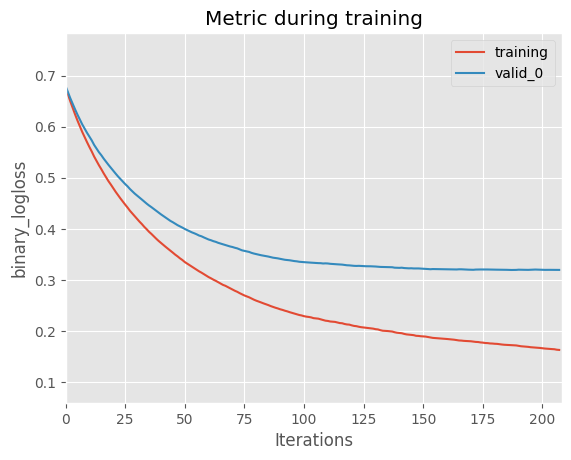

Fold 1: Best Round = 188, Best Logloss = 0.319296
------------------------------------------------------------------------------------------------------------------------

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[200]	training's binary_logloss: 0.175456	valid_0's binary_logloss: 0.287845


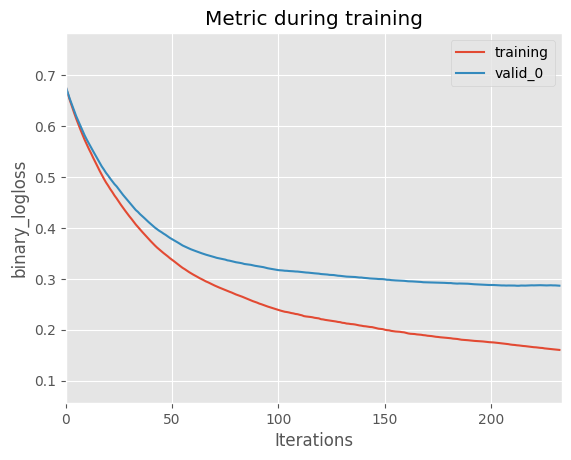

Fold 2: Best Round = 213, Best Logloss = 0.286358
------------------------------------------------------------------------------------------------------------------------

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[200]	training's binary_logloss: 0.169394	valid_0's binary_logloss: 0.299828


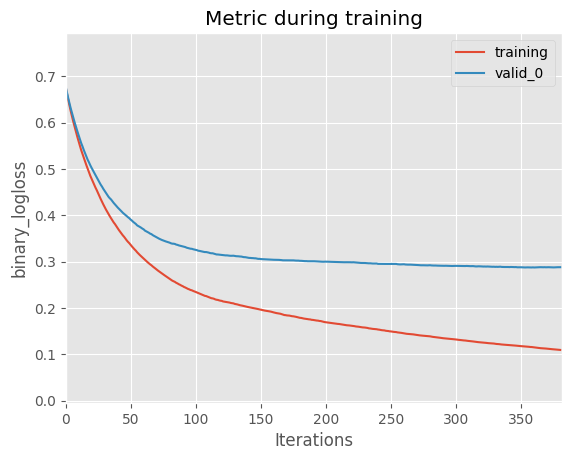

Fold 3: Best Round = 361, Best Logloss = 0.287257
------------------------------------------------------------------------------------------------------------------------

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[200]	training's binary_logloss: 0.165657	valid_0's binary_logloss: 0.344227


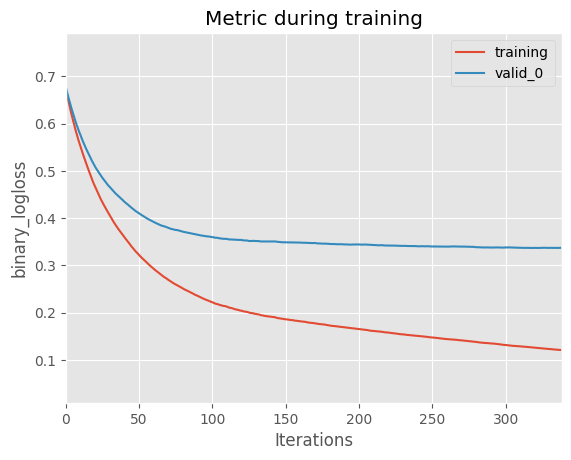

Fold 4: Best Round = 318, Best Logloss = 0.336836
------------------------------------------------------------------------------------------------------------------------

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[200]	training's binary_logloss: 0.171813	valid_0's binary_logloss: 0.287673


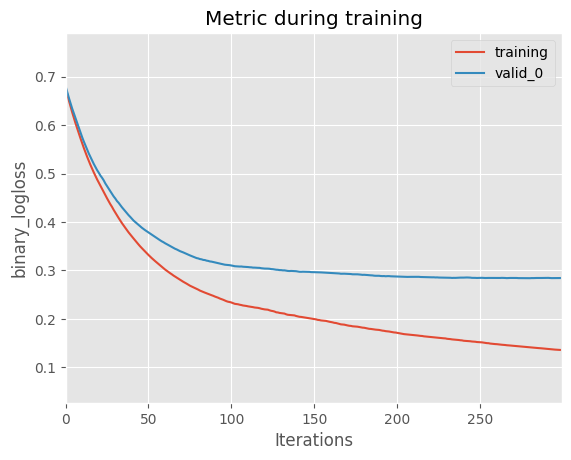

Fold 5: Best Round = 279, Best Logloss = 0.284048
------------------------------------------------------------------------------------------------------------------------

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[200]	training's binary_logloss: 0.173359	valid_0's binary_logloss: 0.300502
[400]	training's binary_logloss: 0.107023	valid_0's binary_logloss: 0.280714


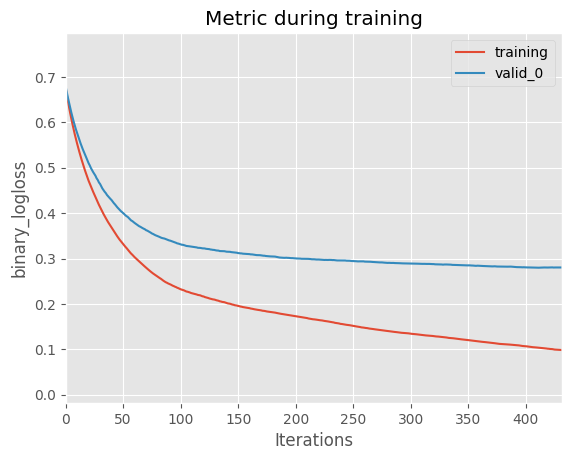

Fold 6: Best Round = 411, Best Logloss = 0.279857
------------------------------------------------------------------------------------------------------------------------

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[200]	training's binary_logloss: 0.177256	valid_0's binary_logloss: 0.320508


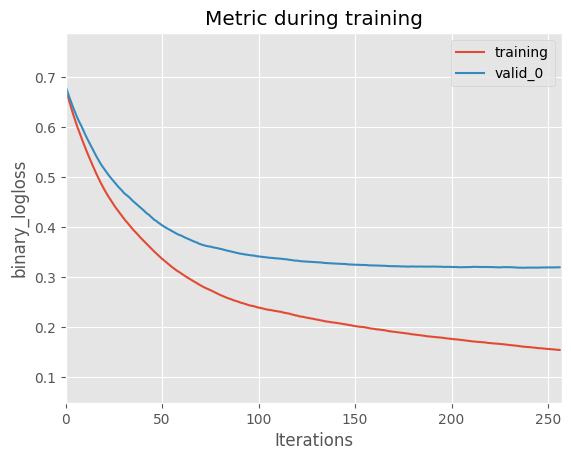

Fold 7: Best Round = 237, Best Logloss = 0.318793
------------------------------------------------------------------------------------------------------------------------

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[200]	training's binary_logloss: 0.164508	valid_0's binary_logloss: 0.301425


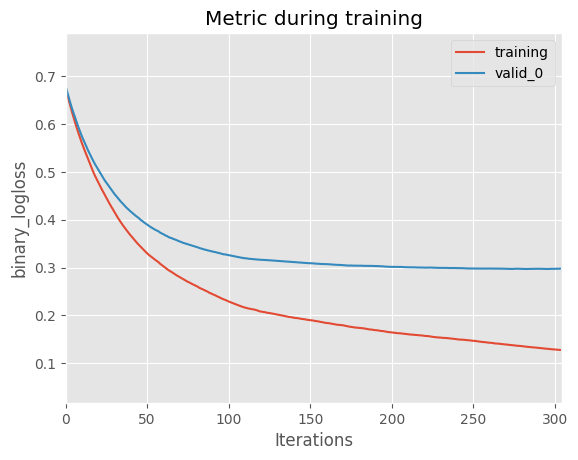

Fold 8: Best Round = 284, Best Logloss = 0.296939
------------------------------------------------------------------------------------------------------------------------

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[200]	training's binary_logloss: 0.171344	valid_0's binary_logloss: 0.330173


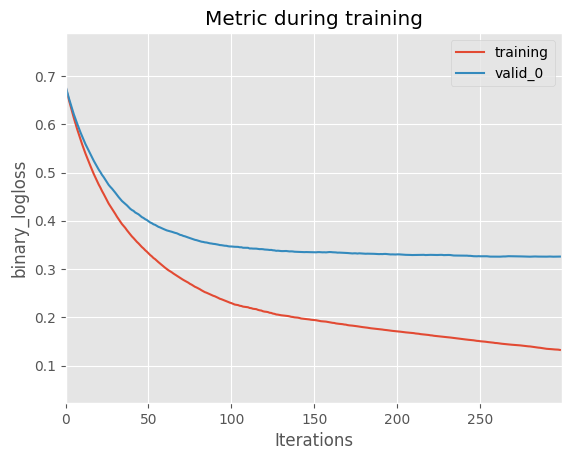

Fold 9: Best Round = 279, Best Logloss = 0.325546
------------------------------------------------------------------------------------------------------------------------

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[200]	training's binary_logloss: 0.174616	valid_0's binary_logloss: 0.324353


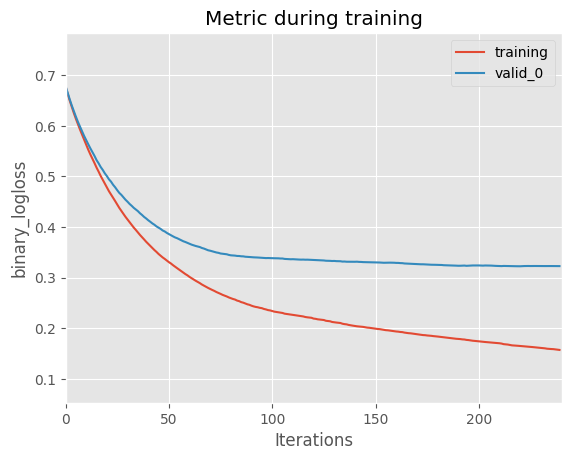

Fold 10: Best Round = 220, Best Logloss = 0.322564
------------------------------------------------------------------------------------------------------------------------

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20


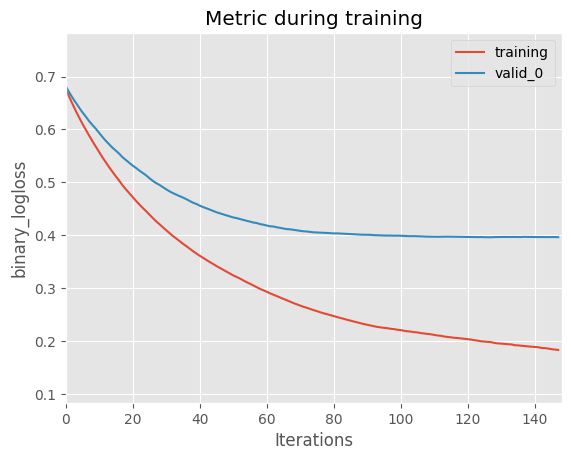

Fold 11: Best Round = 128, Best Logloss = 0.396227
------------------------------------------------------------------------------------------------------------------------

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[200]	training's binary_logloss: 0.176563	valid_0's binary_logloss: 0.301486


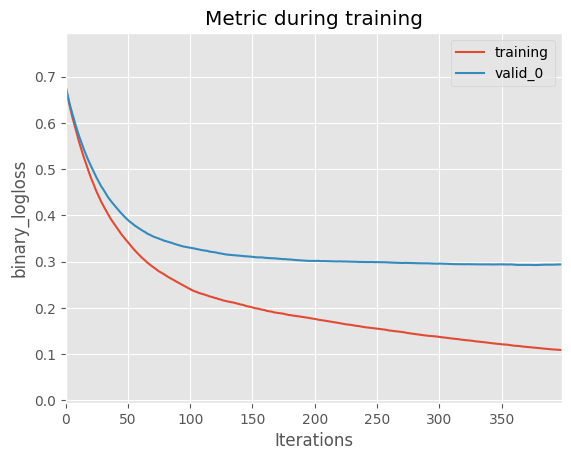

Fold 12: Best Round = 378, Best Logloss = 0.292535
------------------------------------------------------------------------------------------------------------------------

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[200]	training's binary_logloss: 0.180791	valid_0's binary_logloss: 0.286579


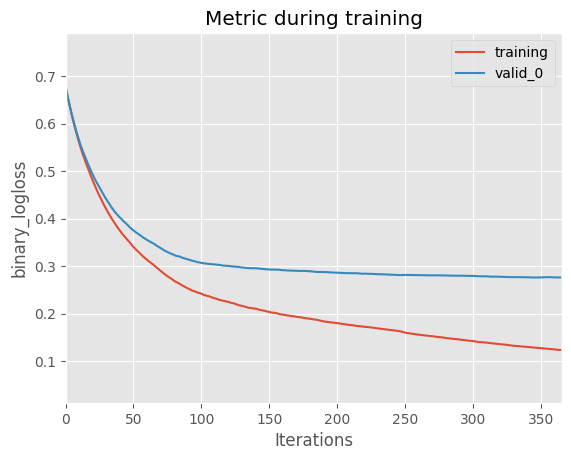

Fold 13: Best Round = 345, Best Logloss = 0.276183
------------------------------------------------------------------------------------------------------------------------

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[200]	training's binary_logloss: 0.163681	valid_0's binary_logloss: 0.325035


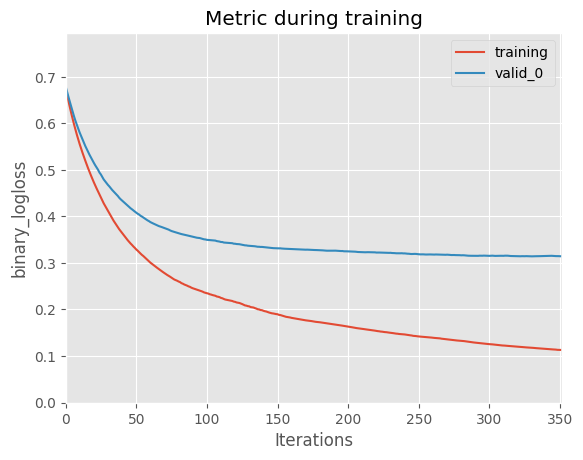

Fold 14: Best Round = 331, Best Logloss = 0.314240
------------------------------------------------------------------------------------------------------------------------

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l2 is set=0.49883949040249276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49883949040249276
[LightGBM] [Warning] num_iterations is set=2701, num_boost_round=2701 will be ignored. Current value: num_iterations=2701
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[200]	training's binary_logloss: 0.169817	valid_0's binary_logloss: 0.280347
[400]	training's binary_logloss: 0.110434	valid_0's binary_logloss: 0.264744


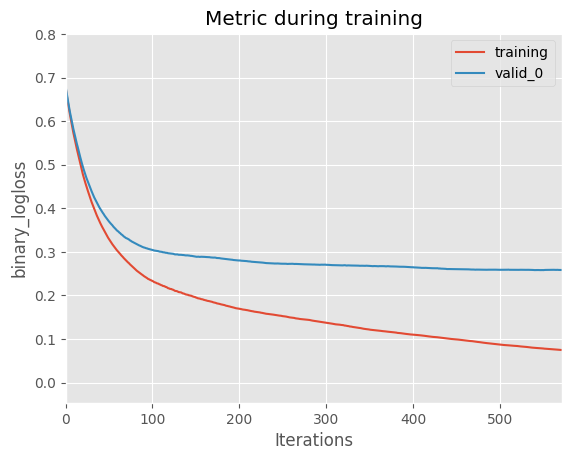

Fold 15: Best Round = 551, Best Logloss = 0.258205
------------------------------------------------------------------------------------------------------------------------

Mean CV Score: 0.870000
Std CV Score: 0.016708


In [29]:
#X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(train2, y, test_size=.3,random_state=seed)

# Define the number of folds for repeated k-fold cross-validation
num_folds = 5  # You can adjust this number as needed
num_repeats = 3  # Adjust as needed
# Split the data into X and y
X = train2
y = y
# Initialize an empty array to store cross-validation scores
cv_scores = []

# Initialize an empty list to store LightGBM datasets
lgb_datasets = []

# Perform group-fold cross-validation
#groups = X['country']
# num_folds = 12
# gkf = sklearn.model_selection.GroupKFold(n_splits=num_folds)

# Perform repeated k-fold cross-validation
rkf = sklearn.model_selection.RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=seed)
for train_index, val_index in rkf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Create LightGBM datasets for training and validation
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    lgb_datasets.append((train_data, val_data))
    
    # Define the LightGBM classifier
    model = lgb.LGBMClassifier(
        objective='binary',  # Assuming you're solving a binary classification problem
        random_state=seed,
        num_threads=4,
        num_boost_round=2701,
        early_stopping_rounds=20,
        learning_rate=0.026441843872389723,  # Adjust as needed
        lambda_l2=0.49883949040249276,
        #boosting_type= 'dart',
        max_depth=5,
        #lambda_l1=.01,  # Adjust lambda values
        #min_child_samples=50  # Increase min_child_samples
    )
    
    # Fit the model
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val), (X_train, y_train)],
        verbose=200,
        eval_metric='binary_logloss'  # Use 'binary_logloss' as the evaluation metric for classification
    )
    
    # Plot the logloss curve for this fold
    ax = lgb.plot_metric(model)
    plt.show()
    
    # Get the best round and best score
    best_round = model.best_iteration_
    best_score = model.best_score_['valid_0']['binary_logloss']
    
    # Print the best round and best score for this fold
    print(f"Fold {len(cv_scores) + 1}: Best Round = {best_round}, Best Logloss = {best_score:.6f}")
    
    print("--"*60)
    print("")
    
    # Calculate and store the accuracy on the validation set for this fold
    val_pred = model.predict(X_val)
    accuracy = np.mean(val_pred == y_val)
    cv_scores.append(accuracy)

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

# Print the mean and standard deviation of the cross-validation scores
print(f"Mean CV Score: {mean_cv_score:.6f}")
print(f"Std CV Score: {std_cv_score:.6f}")

# You can also use this trained model for predictions on the test set
# model.predict(X_test)

***Get Feature Importance***

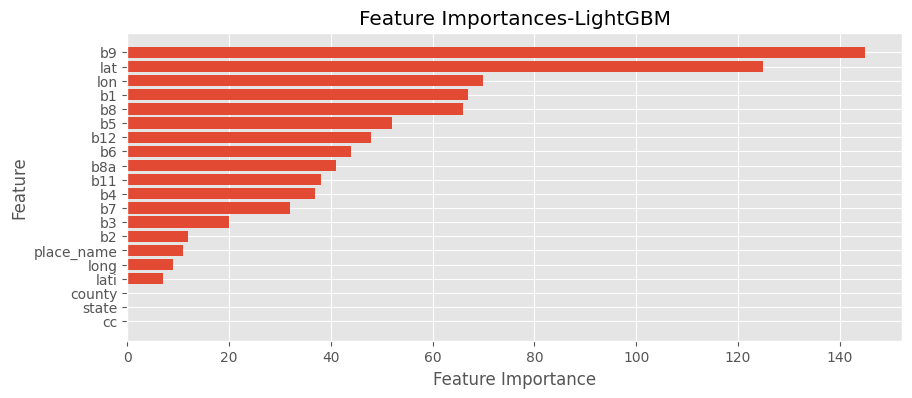

In [30]:
# Get the feature importances from the trained LightGBM model
feature_importances = model.feature_importances_

# Get the names of the features from the X_train columns
feature_names = X_train.columns

# Create a DataFrame to store feature names and their corresponding importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame based on feature importances in ascending order
feature_importance_df = feature_importance_df.head(20).sort_values(by='Importance', ascending=True)

# Plot the feature importances using matplotlib
plt.figure(figsize=(10, 4))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances-LightGBM')
plt.show()

***Inference***

In [31]:
#test_predictions = best_model.fit(X,y) 
#test_predictions = best_model.predict_proba(test2[X_train.columns])[:, 1] 
test_predictions = model.predict_proba(test2[X_train.columns])[:, 1] 
test_predictions = (test_predictions >= 0.5).astype(int)  # Adjust threshold as needed
predictions_test = pd.DataFrame({'ID': test_ids, 'Target': test_predictions})

#predictions_test.drop_duplicates(subset=["ID"],inplace=True)
print(predictions_test.shape)
print("---------------------------")
print(predictions_test["Target"].value_counts())
print("---------------------------")

predictions_test.to_csv("1.lgbm.csv", index=False)
predictions_test.head(3)

(1500, 2)
---------------------------
1    800
0    700
Name: Target, dtype: int64
---------------------------


,ID,Target
2000,ID_OV27436VT055,0
2001,ID_8V2J64GG6RLV,0
2002,ID_DB1QADY40412,0
